In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import scipy as sp
import xgboost as xgb

In [72]:
train = pd.read_csv('train_final.csv')
test = pd.read_csv('test_final.csv')

In [3]:
train.head()

,id,Y,F1,F2,F3,F4,F5,F6,F7,F8,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,1,0,1,0,0.107576,0,0.0,1,1,1,...,104,22902.0,1,0,18,0.042295,1,0,27,0.028250
1,2,0,1,0,0.142357,0,0.0,7,1,1,...,144,11400.0,1,0,8,0.021417,1,0,67,0.253574
2,3,0,1,0,0.492318,0,3.0,4205,1,1,...,112,4833.0,1,0,13,0.502212,1,1,35,0.373397
3,4,0,1,0,-0.053028,0,2.0,2,1,1,...,127,3250.0,1,1,8,0.000000,1,0,50,0.674254
4,5,0,1,0,0.730797,0,0.0,11,1,1,...,148,4000.0,1,1,5,0.787592,1,0,71,0.371157


In [4]:
test.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,49999,1,0,0.460297,0,0.0,1,1,1,1,...,127,5016.0,1,0,8,0.405964,1,2,50,0.943392
1,50000,1,0,0.112573,0,3.0,2,1,1,1,...,137,8300.0,1,5,5,0.100761,1,0,60,0.161306
2,50001,1,0,0.061461,1,0.0,29,1,1,3,...,142,NaN,1,5,4,0.063096,1,0,65,705.000000
3,50002,1,0,0.523372,0,0.0,1,1,1,1,...,160,2500.0,1,1,7,0.534274,1,0,83,0.358657
4,50003,1,0,0.586772,0,2.0,44188,1,1,7,...,106,7472.0,1,4,12,0.759767,1,0,29,0.244748


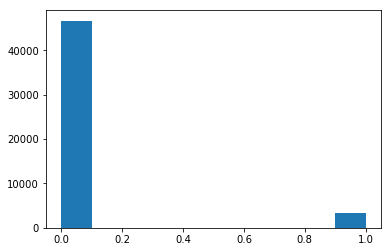

In [5]:
y = train['Y']
#plt.xkcd()  #comment this line if you don't have a sense of humor
plt.hist(y)
plt.show()

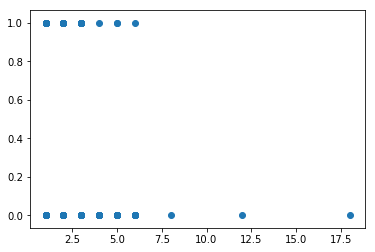

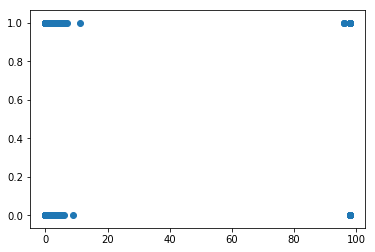

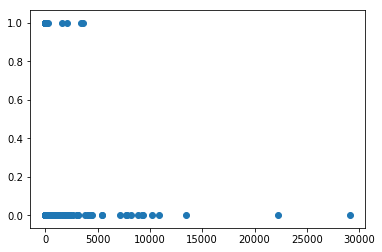

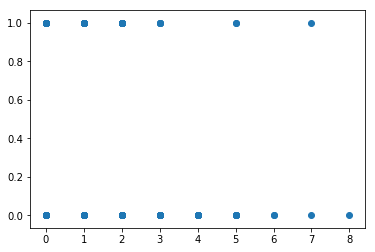

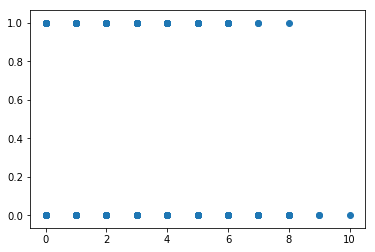

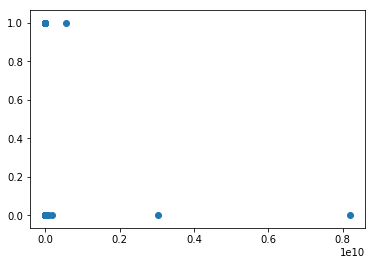

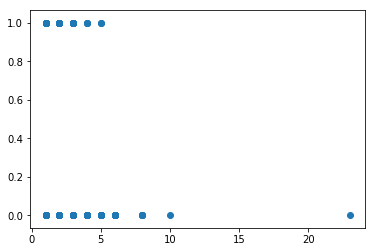

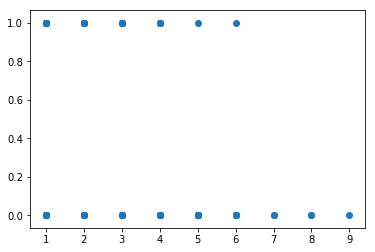

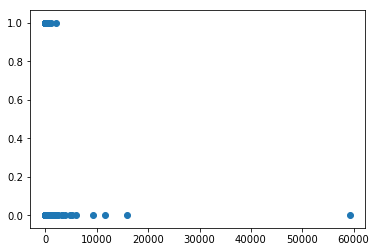

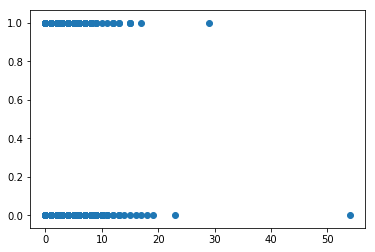

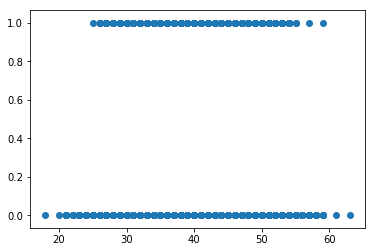

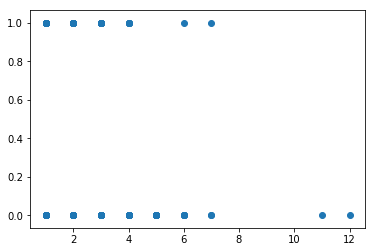

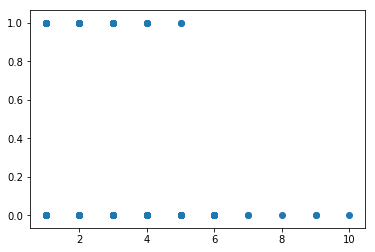

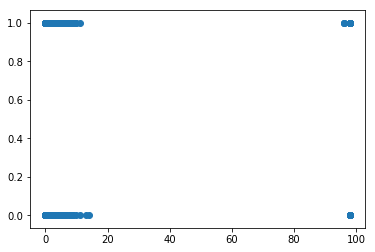

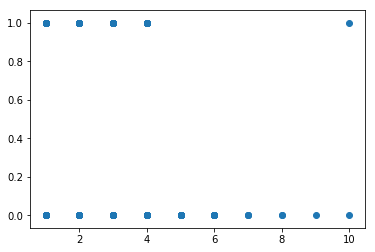

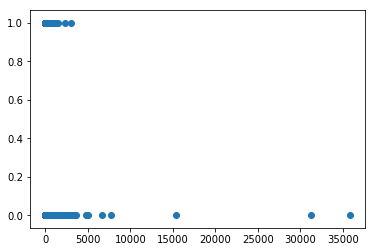

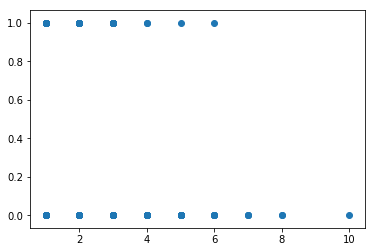

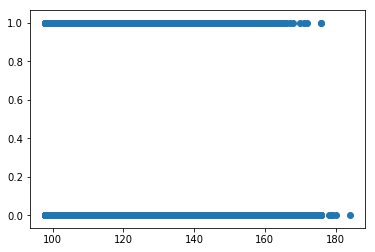

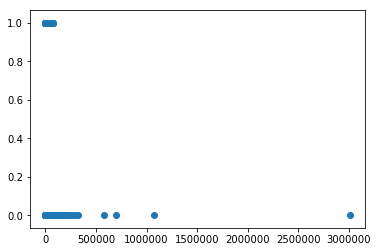

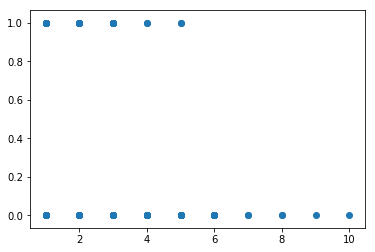

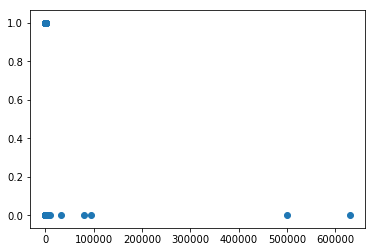

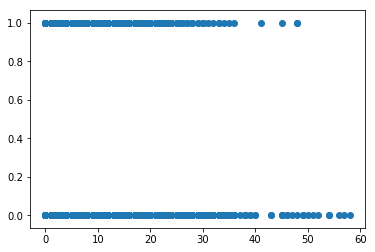

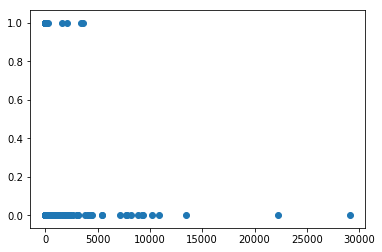

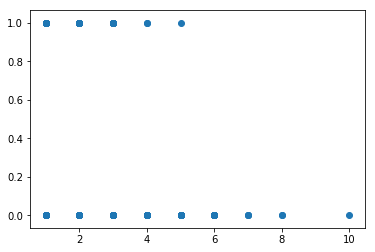

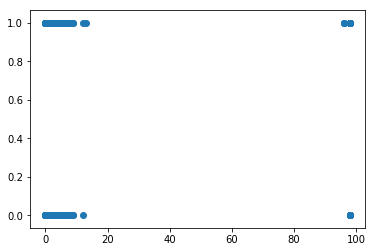

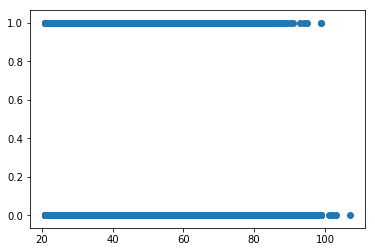

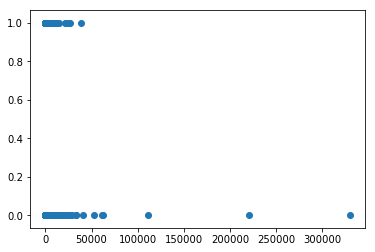

In [6]:
tval = train.values
for i in range(2, 29):
    x = tval[:, i]
    plt.scatter(x , y)
    plt.show()

In [7]:
tval = tval[:, 2:]

In [8]:
tval.shape

(49998, 27)

In [9]:
train.mean()    

id      24999.500000
Y           0.067223
F1          1.043682
F2          0.240510
F3          5.272668
F4          0.043542
F5          0.753478
F6     245419.566383
F7          1.045302
F8          1.041502
F9          7.583423
F10         1.019201
F11        40.017021
F12         1.045402
F13         1.045722
F14         0.267951
F15         1.044182
F16        11.459969
F17         1.041522
F18       129.306232
F19      6665.120065
F20         1.045362
F21        32.148846
F22         8.446638
F23         5.273124
F24         1.043482
F25         0.423617
F26        52.306232
F27       362.038515
dtype: float64

In [10]:
tr_filled = train.fillna(train.mean())

In [11]:
from sklearn import cluster
tval = tr_filled.values[:, 2:]
kmean = cluster.KMeans(n_clusters = 8)
clusters = kmean.fit_predict(tval)

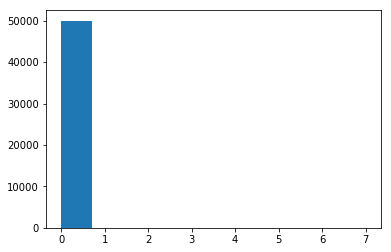

In [12]:
plt.hist(clusters)
plt.show()

In [13]:
#spec = cluster.SpectralClustering(n_clusters = 4)
#subset = tval[np.random.choice(tval.shape[0], 5000, replace=False)]
#clusters = spec.fit_predict(subset)
#plt.hist(clusters)
#plt.show()

Will go for a run. Hopefully some good clusters when I get back.

It is still running. We will not be doing any clustering today...

In [14]:
#let's look for categorical features
pos_cat = []
not_cat = []
for col in train.columns:
    x = len(train[col].unique())
    if x < 100:
        pos_cat.append(col)
    else:
        not_cat.append(col)
    print x, col

49998 id
2 Y
9 F1
12 F2
49998 F3
9 F4
12 F5
1880 F6
9 F7
9 F8
322 F9
23 F10
43 F11
9 F12
10 F13
16 F14
10 F15
310 F16
9 F17
83 F18
8771 F19
10 F20
334 F21
55 F22
42562 F23
9 F24
14 F25
83 F26
41705 F27


To test to see if these features are categorical, let's try a model with one hot encoding and one without.

In [15]:
print pos_cat

['Y', 'F1', 'F2', 'F4', 'F5', 'F7', 'F8', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F17', 'F18', 'F20', 'F22', 'F24', 'F25', 'F26']


In [16]:
from sklearn import metrics
import time

#useful code
def get_submission(x, name):
    sub = {'id':id, 'ACTION':x}
    sub = pd.DataFrame(data=sub, columns=['id', 'ACTION'])
    sub.to_csv(name, index=False)
    
#how kaggle computes a score
def evaluate(preds, true_labels):
    fpr, tpr, thresholds = metrics.roc_curve(true_labels, preds, pos_label=1)
    auc = metrics.auc(fpr,tpr)
    return auc

def transform(preds):
    for i in range(0, len(preds)):
        if preds[i] > 0.5:
            preds[i]=1
        else:
            preds[i]=0
    return preds

def cv(params, estimators, tr_x, y):
    start = time.time()
    expected_err = [0]*len(params);
    expected_err_stump = 0;
    xgbs=[]
    for i in range(0, 10):
        print i*10, '% complete'
        x_train, x_test, y_train, y_test = sk.model_selection.train_test_split(tr_x, y, test_size=0.4, random_state=21)
        x_train = xgb.DMatrix(data=x_train, label=y_train)
        x_test = xgb.DMatrix(data=x_test)
        for i in range(0, len(params)):
            xgbs.append(xgb.train(params[i], dtrain=x_train, num_boost_round=estimators[i]))
            expected_err[i] += evaluate(transform(xgbs[i].predict(x_test)), y_test)
    print '100% Complete'
    for i in range(0, len(params)):
        expected_err[i] = expected_err[i]/10
        print 'Model ', i, ": ", expected_err[i]
    run_time = time.time()-start
    print 'run time: ', int(run_time)/60,'m',run_time%60, 's'

In [17]:
pos_cat = pos_cat[1:]

In [18]:
print pos_cat

['F1', 'F2', 'F4', 'F5', 'F7', 'F8', 'F10', 'F11', 'F12', 'F13', 'F14', 'F15', 'F17', 'F18', 'F20', 'F22', 'F24', 'F25', 'F26']


In [19]:
len(pos_cat)

19

In [20]:
from sklearn import preprocessing as pre
onehot = train[pos_cat].fillna(0)
onehot = pre.OneHotEncoder(sparse = False).fit_transform(onehot)

In [21]:
print onehot

[[ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]
 [ 1.  0.  0. ...,  0.  0.  0.]]


In [22]:
print type(onehot)
print not_cat

<type 'numpy.ndarray'>
['id', 'F3', 'F6', 'F9', 'F16', 'F19', 'F21', 'F23', 'F27']


In [23]:
train_one_hot = np.hstack([tr_filled[not_cat].values, onehot])

In [24]:
train_no_hot = tr_filled.values[:,2:]

In [25]:
params = {}
params['learning_rate'] = 0.3
params['objective'] = 'binary:logistic'
params['updater'] = 'grow_gpu'

In [26]:
print len(y[y == 1])
print len(y[y==0])


3361
46637


In [27]:
cv([params], [100], train_one_hot, y)

0 % complete
10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
100% Complete
Model  0 :  0.581639758303
run time:  1 m 21.0907781124 s


In [28]:
cv([params], [100], train_no_hot, y)

0 % complete
10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
100% Complete
Model  0 :  0.57855808688
run time:  0 m 10.0915539265 s


In [29]:
cv([params], [100], train_no_hot, y)

0 % complete
10 % complete
20 % complete
30 % complete
40 % complete
50 % complete
60 % complete
70 % complete
80 % complete
90 % complete
100% Complete
Model  0 :  0.57855808688
run time:  0 m 10.6713759899 s


In [30]:
tester = test.values
print train_no_hot.shape
print tester.shape

(49998, 27)
(50000, 28)


In [31]:
trainer = xgb.DMatrix(data=train_no_hot, label=y)
sub1 = xgb.train(params, trainer)
tester = xgb.DMatrix(data=test.values)
preds = sub1.predict(tester)

ValueError: feature_names mismatch: ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26'] ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27']
training data did not have the following fields: f27

In [ ]:
#trying a logistic regresion
lgr = {'booster':'gblinear'}
cv([lgr],[50], train_no_hot, y)

In [ ]:
lp = []
estimators = []
for i in range(0, 10):
    lgr = {'booster':'gblinear'}
    lgr['alpha'] = float(i)/10
    cv([lgr], [50], train_no_hot, y)

In [ ]:
#trying a logistic regresion
lgr = {'booster':'gblinear'}
cv([lgr],[50], train_one_hot, y)

In [ ]:
tr_filled = train.fillna(train.mean())
del tr_filled['Y']
del tr_filled['id']

In [ ]:
tr_filled.head()

In [ ]:
for col in pos_cat:
    print col
    temp = train.fillna(train.mean())
    del temp['Y']
    del temp['id']
    one = temp[col].values
    del temp[col]
    one.shape = [len(one),1]
    one = pre.OneHotEncoder(sparse=False).fit_transform(one)
    print one.shape
    print temp.values.shape
    onehot = np.hstack([temp.values, one])
    print temp.shape
    cv([lgr], [50], onehot, y)

f2, f14 both got better after one hot encoding.
f25 saw marginal improvement.
Let's try the same thing with the trees.

In [ ]:
params = {}
params['learning_rate'] = 0.3
params['objective'] = 'binary:logistic'
params['updater'] = 'grow_gpu'
for col in pos_cat:
    print col
    temp = train.fillna(train.mean())
    del temp['Y']
    del temp['id']
    one = temp[col].values
    del temp[col]
    one.shape = [len(one),1]
    one = pre.OneHotEncoder(sparse=False).fit_transform(one)
    onehot = np.hstack([temp.values, one])
    cv([params], [50], onehot, y)

We saw very little change here.

In [ ]:
#let's do a quick PCA
#print tr_filled.head()
from sklearn import decomposition
pca = decomposition.PCA()
pca.fit(tr_filled)
cov = pca.get_covariance()

lets one hot encode f2, f14, and f25

In [33]:
tr_filled.head()

,id,Y,F1,F2,F3,F4,F5,F6,F7,F8,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,1,0,1,0,0.107576,0,0.0,1,1,1,...,104,22902.0,1,0,18,0.042295,1,0,27,0.028250
1,2,0,1,0,0.142357,0,0.0,7,1,1,...,144,11400.0,1,0,8,0.021417,1,0,67,0.253574
2,3,0,1,0,0.492318,0,3.0,4205,1,1,...,112,4833.0,1,0,13,0.502212,1,1,35,0.373397
3,4,0,1,0,-0.053028,0,2.0,2,1,1,...,127,3250.0,1,1,8,0.000000,1,0,50,0.674254
4,5,0,1,0,0.730797,0,0.0,11,1,1,...,148,4000.0,1,1,5,0.787592,1,0,71,0.371157


In [71]:
train.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,1,1,0,0.107576,0,0.0,1,1,1,1,...,104,22902.0,1,0,18,0.042295,1,0,27,0.028250
1,2,1,0,0.142357,0,0.0,7,1,1,1,...,144,11400.0,1,0,8,0.021417,1,0,67,0.253574
2,3,1,0,0.492318,0,3.0,4205,1,1,3,...,112,4833.0,1,0,13,0.502212,1,1,35,0.373397
3,4,1,0,-0.053028,0,2.0,2,1,1,5,...,127,3250.0,1,1,8,0.000000,1,0,50,0.674254
4,5,1,0,0.730797,0,0.0,11,1,1,1,...,148,4000.0,1,1,5,0.787592,1,0,71,0.371157


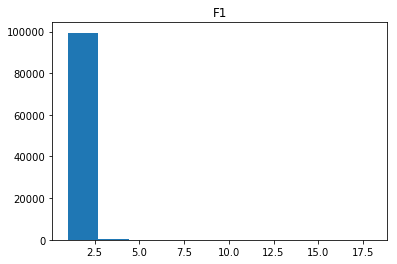

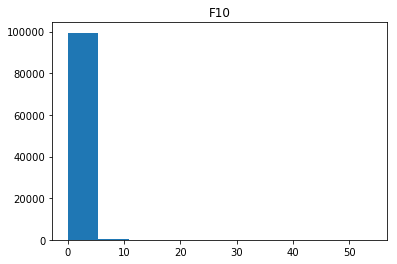

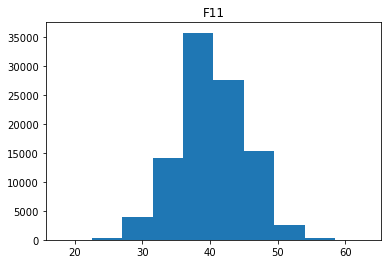

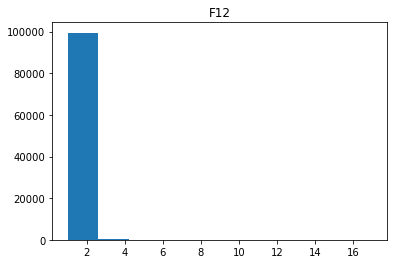

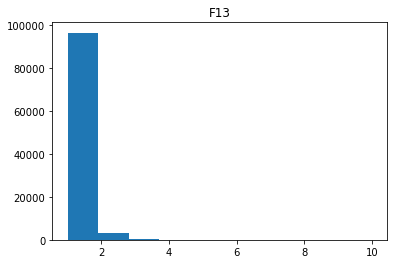

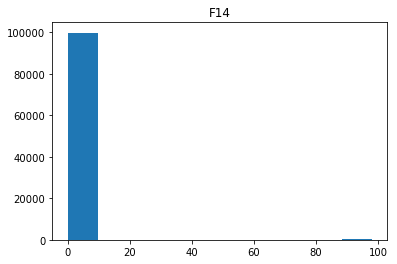

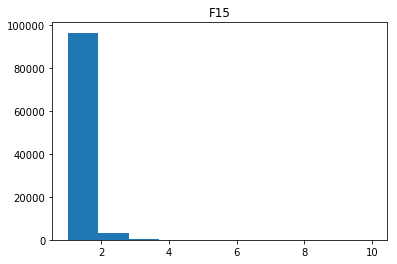

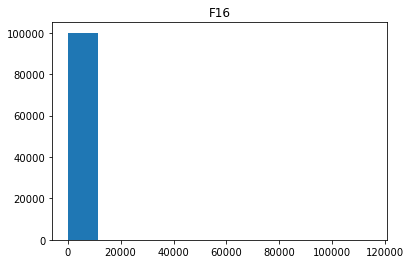

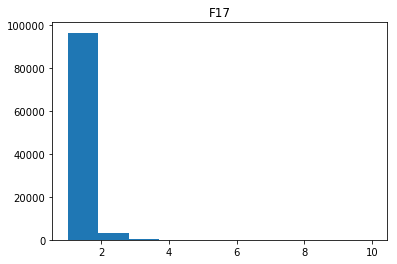

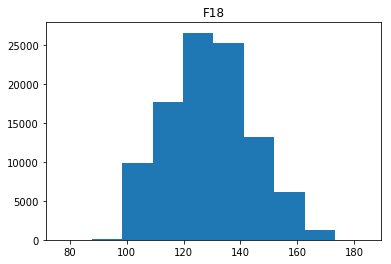

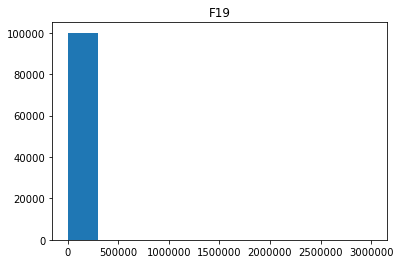

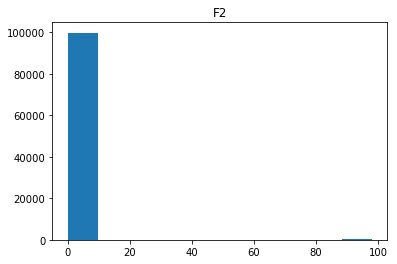

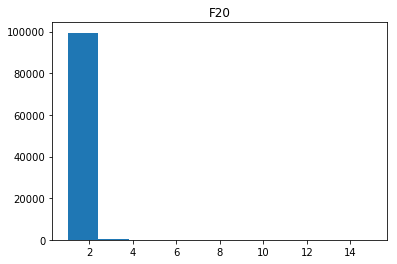

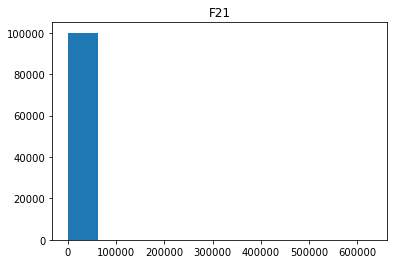

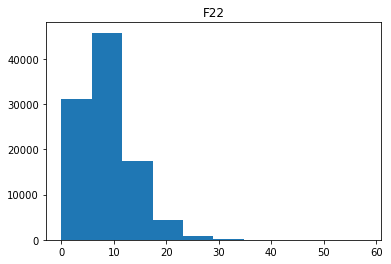

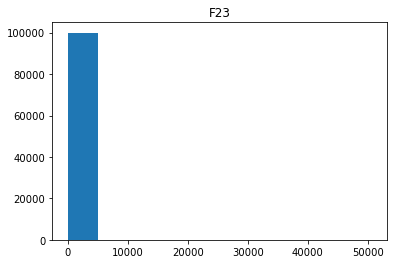

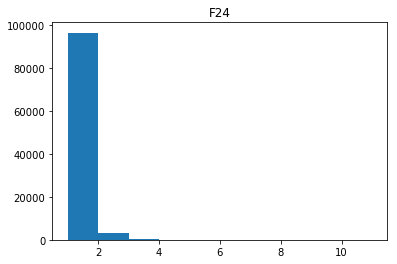

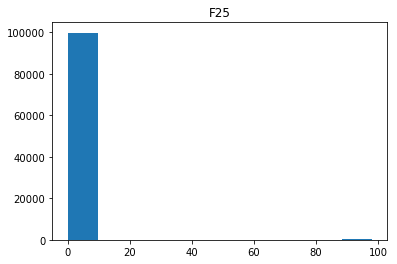

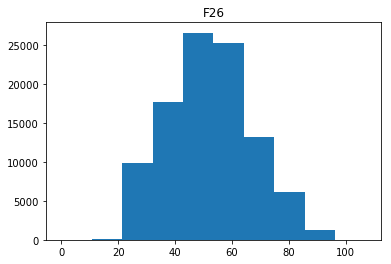

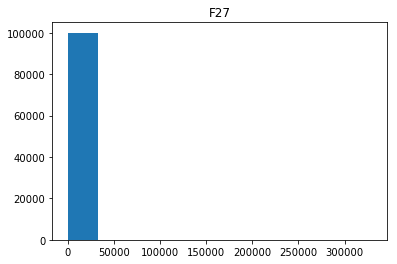

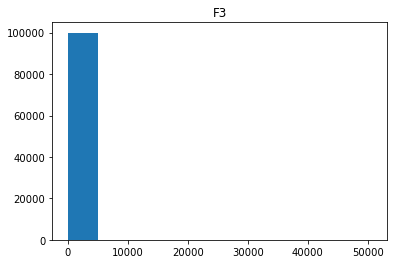

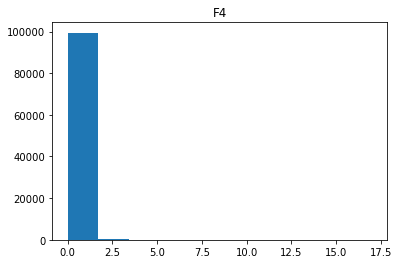

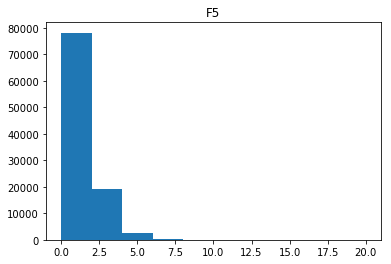

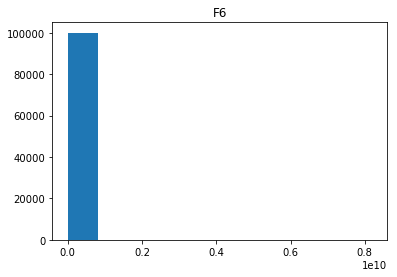

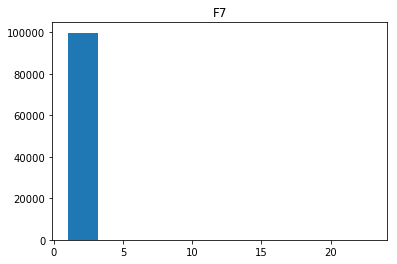

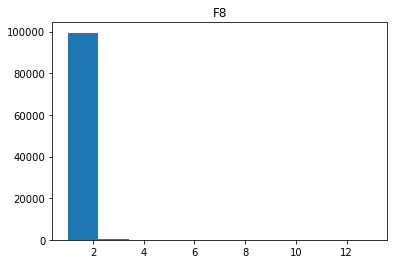

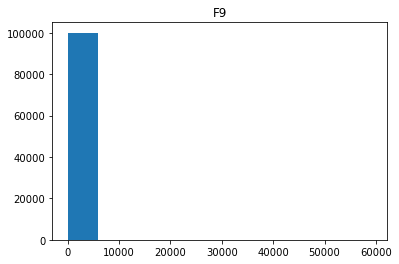

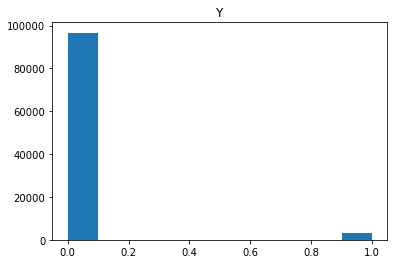

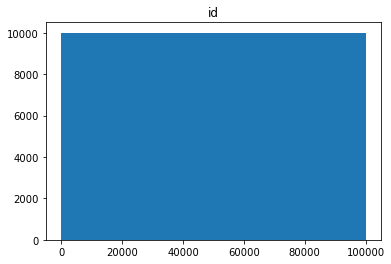

In [73]:
cols = train.columns
tcols = test.columns
alldata = pd.concat([train, test])
fixed_data = alldata.fillna(alldata.mean())
for col in alldata.columns:
    plt.hist(fixed_data[col])
    plt.title(col)
    plt.show()

In [107]:
ordered_cols = train.columns
fixed_data = fixed_data[ordered_cols]
del fixed_data['Y']
fixed_data.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,1,1,0,0.107576,0,0.0,1,1,1,1,...,104,22902.0,1,0,18,0.042295,1,0,27,0.028250
1,2,1,0,0.142357,0,0.0,7,1,1,1,...,144,11400.0,1,0,8,0.021417,1,0,67,0.253574
2,3,1,0,0.492318,0,3.0,4205,1,1,3,...,112,4833.0,1,0,13,0.502212,1,1,35,0.373397
3,4,1,0,-0.053028,0,2.0,2,1,1,5,...,127,3250.0,1,1,8,0.000000,1,0,50,0.674254
4,5,1,0,0.730797,0,0.0,11,1,1,1,...,148,4000.0,1,1,5,0.787592,1,0,71,0.371157


In [108]:
cols_to_onehot = ['F2', 'F14', 'F25']
categs = []
cols = fixed_data.columns
for i in range(0, len(cols)):
    if cols[i] in cols_to_onehot:
        categs.append(i)
#temp1 = fixed_data
#onehot = temp1[cols_to_onehot]
print categs
onehot = pre.OneHotEncoder(categorical_features=categs, sparse=False).fit(fixed_data)

[2, 14, 25]


In [76]:
onehot

OneHotEncoder(categorical_features=[3, 15, 26], dtype=<type 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=False)

In [78]:
train.head()

,id,Y,F1,F2,F3,F4,F5,F6,F7,F8,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,1,0,1,0,0.107576,0,0.0,1,1,1,...,104,22902.0,1,0,18,0.042295,1,0,27,0.028250
1,2,0,1,0,0.142357,0,0.0,7,1,1,...,144,11400.0,1,0,8,0.021417,1,0,67,0.253574
2,3,0,1,0,0.492318,0,3.0,4205,1,1,...,112,4833.0,1,0,13,0.502212,1,1,35,0.373397
3,4,0,1,0,-0.053028,0,2.0,2,1,1,...,127,3250.0,1,1,8,0.000000,1,0,50,0.674254
4,5,0,1,0,0.730797,0,0.0,11,1,1,...,148,4000.0,1,1,5,0.787592,1,0,71,0.371157


In [109]:
label = train['Y']
del train['Y']
onehot_tr = onehot.transform(train.fillna(train.mean()))
onehot_test = onehot.transform(test.fillna(test.mean()))

In [124]:
def modelfit(alg, dtrain, label, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    start = time.time()
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=label.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=None)
        alg.set_params(n_estimators=cvresult.shape[0])
        print 'n_estimators ', cvresult.shape[0]
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], label,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(label.values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(label, dtrain_predprob)
    run_time = time.time()-start
    print 'run time: ', int(run_time)/60,'m',run_time%60, 's'                
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()
    return cvresult

n_estimators  70

Model Report
Accuracy : 0.9431
AUC Score (Train): 0.888087
run time:  0 m 30.2235541344 s


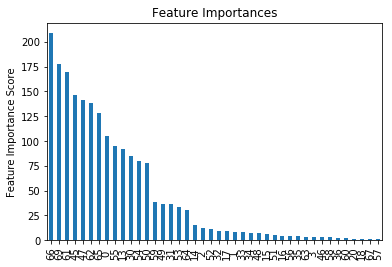

In [125]:
#maybe will use later
#params = {}
#params['max_depth'] = 5
#params['learning_rate'] = 0.3
#params['objective'] = 'binary:logistic'
#params['updater'] = 'grow_gpu'
one_tr = pd.DataFrame(data=onehot_tr)
target = 1
predictors = [x for x in one_tr.columns if x not in [id]]
xgb1 = xgb.XGBClassifier(learning_rate = 0.1, n_estimators=1000, max_depth=5, min_child_weight=1, gamma=0,subsample=0.8, objective='binary:logistic', scale_pos_weight=1, seed=27)
cvr = modelfit(xgb1, one_tr, label, predictors=predictors)

In [126]:
cvr

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.832931,0.007690,0.838083,0.003942
1,0.839526,0.005360,0.845065,0.001486
2,0.842024,0.006108,0.847672,0.000743
3,0.844761,0.004100,0.849964,0.000899
4,0.844847,0.003940,0.850620,0.000883
5,0.845229,0.004289,0.850924,0.000812
6,0.845614,0.004179,0.851855,0.001388
7,0.845612,0.004237,0.852192,0.001444
8,0.846716,0.004402,0.853483,0.002061
9,0.848972,0.005490,0.855229,0.001658


In [140]:
p_testn = {'n_estimators':[50, 100, 200, 500, 750, 1000]}
gsearchn= sk.model_selection.GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), param_grid = p_testn, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearchn.fit(one_tr, label)
gsearchn.grid_scores_, gsearchn.best_params_, gsearchn.best_score_

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85518, std: 0.01196, params: {'n_estimators': 50},
  mean: 0.85384, std: 0.01417, params: {'n_estimators': 100},
  mean: 0.84883, std: 0.01438, params: {'n_estimators': 200},
  mean: 0.82980, std: 0.01880, params: {'n_estimators': 500},
  mean: 0.81765, std: 0.02317, params: {'n_estimators': 750},
  mean: 0.80883, std: 0.02840, params: {'n_estimators': 1000}],
 {'n_estimators': 50},
 0.85518397266807722)

In [141]:
p_testn = {'n_estimators':[50, 60, 70, 80, 90]}
gsearchn= sk.model_selection.GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), param_grid = p_testn, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearchn.fit(one_tr, label)
gsearchn.grid_scores_, gsearchn.best_params_, gsearchn.best_score_

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85518, std: 0.01196, params: {'n_estimators': 50},
  mean: 0.85506, std: 0.01271, params: {'n_estimators': 60},
  mean: 0.85534, std: 0.01305, params: {'n_estimators': 70},
  mean: 0.85482, std: 0.01346, params: {'n_estimators': 80},
  mean: 0.85428, std: 0.01374, params: {'n_estimators': 90}],
 {'n_estimators': 70},
 0.8553409682979376)

In [142]:
p_testn = {'n_estimators':[65, 68, 70, 72, 75]}
gsearchn= sk.model_selection.GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), param_grid = p_testn, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearchn.fit(one_tr, label)
gsearchn.grid_scores_, gsearchn.best_params_, gsearchn.best_score_

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85539, std: 0.01287, params: {'n_estimators': 65},
  mean: 0.85537, std: 0.01307, params: {'n_estimators': 68},
  mean: 0.85534, std: 0.01305, params: {'n_estimators': 70},
  mean: 0.85524, std: 0.01329, params: {'n_estimators': 72},
  mean: 0.85511, std: 0.01331, params: {'n_estimators': 75}],
 {'n_estimators': 65},
 0.85538881681691703)

In [143]:
p_testn = {'n_estimators':[63, 64, 65, 66, 67]}
gsearchn= sk.model_selection.GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), param_grid = p_testn, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearchn.fit(one_tr, label)
gsearchn.grid_scores_, gsearchn.best_params_, gsearchn.best_score_

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85523, std: 0.01282, params: {'n_estimators': 63},
  mean: 0.85533, std: 0.01288, params: {'n_estimators': 64},
  mean: 0.85539, std: 0.01287, params: {'n_estimators': 65},
  mean: 0.85536, std: 0.01290, params: {'n_estimators': 66},
  mean: 0.85533, std: 0.01302, params: {'n_estimators': 67}],
 {'n_estimators': 65},
 0.85538881681691703)

In [144]:
p_test1 = {'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)}
gsearch1= sk.model_selection.GridSearchCV(estimator = xgb.XGBClassifier(learning_rate =0.1, n_estimators=65, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), param_grid = p_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(one_tr, label)
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85908, std: 0.00801, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.85892, std: 0.00797, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: 0.85890, std: 0.00785, params: {'max_depth': 3, 'min_child_weight': 5},
  mean: 0.85539, std: 0.01287, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.85814, std: 0.00779, params: {'max_depth': 5, 'min_child_weight': 3},
  mean: 0.85947, std: 0.00728, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.84623, std: 0.02118, params: {'max_depth': 7, 'min_child_weight': 1},
  mean: 0.85419, std: 0.00902, params: {'max_depth': 7, 'min_child_weight': 3},
  mean: 0.85567, std: 0.00811, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: 0.83759, std: 0.02779, params: {'max_depth': 9, 'min_child_weight': 1},
  mean: 0.84955, std: 0.01098, params: {'max_depth': 9, 'min_child_weight': 3},
  mean: 0.85236, std: 0.00849, params: {'max_depth': 9, 'min_child_weight': 5}],
 {'max_depth': 5, 'min_child_weight': 5

In [145]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
xgb2 = xgb.XGBClassifier( learning_rate=0.1, n_estimators=65, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
gs2 = sk.model_selection.GridSearchCV(estimator = xgb2,param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gs2.fit(one_tr,y)

GridSearchCV(cv=5, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.8,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=5,
       min_child_weight=2, missing=None, n_estimators=65, nthread=4,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=27, silent=True, subsample=0.8),
       fit_params={}, iid=False, n_jobs=4,
       param_grid={'max_depth': [4, 5, 6], 'min_child_weight': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [146]:
gs2.grid_scores_, gs2.best_params_, gs2.best_score_

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85921, std: 0.00729, params: {'max_depth': 4, 'min_child_weight': 4},
  mean: 0.85921, std: 0.00743, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: 0.85943, std: 0.00742, params: {'max_depth': 4, 'min_child_weight': 6},
  mean: 0.85846, std: 0.00735, params: {'max_depth': 5, 'min_child_weight': 4},
  mean: 0.85947, std: 0.00728, params: {'max_depth': 5, 'min_child_weight': 5},
  mean: 0.85881, std: 0.00789, params: {'max_depth': 5, 'min_child_weight': 6},
  mean: 0.85709, std: 0.00818, params: {'max_depth': 6, 'min_child_weight': 4},
  mean: 0.85773, std: 0.00728, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: 0.85777, std: 0.00736, params: {'max_depth': 6, 'min_child_weight': 6}],
 {'max_depth': 5, 'min_child_weight': 5},
 0.85946678668372978)

In [151]:
pt3 = {'min_child_weight':[2, 4, 6, 8, 10]}
xgb2 = xgb.XGBClassifier( learning_rate=0.1, n_estimators=65, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
gs3 = sk.model_selection.GridSearchCV(estimator = xgb2,param_grid = pt3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gs3.fit(one_tr,y)
gs3.grid_scores_, gs3.best_params_, gs3.best_score_

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85738, std: 0.00870, params: {'min_child_weight': 2},
  mean: 0.85846, std: 0.00735, params: {'min_child_weight': 4},
  mean: 0.85881, std: 0.00789, params: {'min_child_weight': 6},
  mean: 0.85939, std: 0.00761, params: {'min_child_weight': 8},
  mean: 0.85927, std: 0.00761, params: {'min_child_weight': 10}],
 {'min_child_weight': 8},
 0.85938990736719778)

In [152]:
pt3 = {'min_child_weight':[7, 8, 9]}
xgb2 = xgb.XGBClassifier( learning_rate=0.1, n_estimators=65, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
gs3 = sk.model_selection.GridSearchCV(estimator = xgb2,param_grid = pt3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gs3.fit(one_tr,y)
gs3.grid_scores_, gs3.best_params_, gs3.best_score_

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85925, std: 0.00729, params: {'min_child_weight': 7},
  mean: 0.85939, std: 0.00761, params: {'min_child_weight': 8},
  mean: 0.85940, std: 0.00734, params: {'min_child_weight': 9}],
 {'min_child_weight': 9},
 0.85940486474276179)

In [153]:
pt3 = {'min_child_weight':[8, 9, 10]}
xgb2 = xgb.XGBClassifier( learning_rate=0.1, n_estimators=65, max_depth=5,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
gs3 = sk.model_selection.GridSearchCV(estimator = xgb2,param_grid = pt3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gs3.fit(one_tr,y)
gs3.grid_scores_, gs3.best_params_, gs3.best_score_

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85939, std: 0.00761, params: {'min_child_weight': 8},
  mean: 0.85940, std: 0.00734, params: {'min_child_weight': 9},
  mean: 0.85927, std: 0.00761, params: {'min_child_weight': 10}],
 {'min_child_weight': 9},
 0.85940486474276179)

In [156]:
ptgamma = {'gamma':[i/10.0 for i in range(0,5)]}
xgb3 = xgb.XGBClassifier( learning_rate=0.1, n_estimators=65, max_depth=5,
 min_child_weight=9, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
gsgamma = sk.model_selection.GridSearchCV(estimator = xgb3,param_grid = ptgamma, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsgamma.fit(one_tr,y)
gsgamma.grid_scores_, gsgamma.best_params_, gsgamma.best_score_

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85940, std: 0.00734, params: {'gamma': 0.0},
  mean: 0.85904, std: 0.00720, params: {'gamma': 0.1},
  mean: 0.85886, std: 0.00746, params: {'gamma': 0.2},
  mean: 0.85893, std: 0.00752, params: {'gamma': 0.3},
  mean: 0.85906, std: 0.00766, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 0.85940486474276179)

In [159]:
xgb4 = xgb.XGBClassifier( learning_rate=0.1, n_estimators=65, max_depth=5,
 min_child_weight=9, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
param_sub_col = {
    'subsample':[i/10.0 for i in range(6,10)],
    'colsample_bytree':[i/10.0 for i in range(6, 10)]
}
gscol = sk.model_selection.GridSearchCV(estimator = xgb4,param_grid = param_sub_col, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gscol.fit(one_tr,y)
gscol.grid_scores_, gscol.best_params_, gscol.best_score_

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85922, std: 0.00774, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: 0.85855, std: 0.00790, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: 0.85989, std: 0.00775, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: 0.85956, std: 0.00776, params: {'subsample': 0.9, 'colsample_bytree': 0.6},
  mean: 0.85902, std: 0.00735, params: {'subsample': 0.6, 'colsample_bytree': 0.7},
  mean: 0.85873, std: 0.00763, params: {'subsample': 0.7, 'colsample_bytree': 0.7},
  mean: 0.85937, std: 0.00697, params: {'subsample': 0.8, 'colsample_bytree': 0.7},
  mean: 0.85930, std: 0.00709, params: {'subsample': 0.9, 'colsample_bytree': 0.7},
  mean: 0.85903, std: 0.00707, params: {'subsample': 0.6, 'colsample_bytree': 0.8},
  mean: 0.85976, std: 0.00752, params: {'subsample': 0.7, 'colsample_bytree': 0.8},
  mean: 0.85940, std: 0.00734, params: {'subsample': 0.8, 'colsample_bytree': 0.8},
  mean: 0.85873, std: 0.00757, params: {'subsample': 0.9, 'colsample_bytree'

In [160]:
xgb4 = xgb.XGBClassifier( learning_rate=0.1, n_estimators=65, max_depth=5,
 min_child_weight=9, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
param_sub_col = {
    'subsample':[i/100.0 for i in range(75, 85)],
    'colsample_bytree':[i/100.0 for i in range(55, 65)]
}
gscol = sk.model_selection.GridSearchCV(estimator = xgb4,param_grid = param_sub_col, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gscol.fit(one_tr,y)
gscol.grid_scores_, gscol.best_params_, gscol.best_score_

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85926, std: 0.00735, params: {'subsample': 0.75, 'colsample_bytree': 0.55},
  mean: 0.85937, std: 0.00764, params: {'subsample': 0.76, 'colsample_bytree': 0.55},
  mean: 0.85941, std: 0.00782, params: {'subsample': 0.77, 'colsample_bytree': 0.55},
  mean: 0.85891, std: 0.00788, params: {'subsample': 0.78, 'colsample_bytree': 0.55},
  mean: 0.85931, std: 0.00749, params: {'subsample': 0.79, 'colsample_bytree': 0.55},
  mean: 0.85913, std: 0.00786, params: {'subsample': 0.8, 'colsample_bytree': 0.55},
  mean: 0.85906, std: 0.00724, params: {'subsample': 0.81, 'colsample_bytree': 0.55},
  mean: 0.85931, std: 0.00760, params: {'subsample': 0.82, 'colsample_bytree': 0.55},
  mean: 0.85934, std: 0.00745, params: {'subsample': 0.83, 'colsample_bytree': 0.55},
  mean: 0.85984, std: 0.00785, params: {'subsample': 0.84, 'colsample_bytree': 0.55},
  mean: 0.85879, std: 0.00734, params: {'subsample': 0.75, 'colsample_bytree': 0.56},
  mean: 0.85882, std: 0.00752, params: {'subsample': 0.

In [161]:
xgbln = xgb.XGBClassifier( learning_rate=0.1, n_estimators=65, max_depth=5,
 min_child_weight=9, gamma=0, subsample=0.84, colsample_bytree=0.59,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
pln = {
    'learning_rate':[i/10.0 for i in range(0, 10)]
}
gsln = sk.model_selection.GridSearchCV(estimator = xgbln,param_grid = pln, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsln.fit(one_tr,y)
gsln.grid_scores_, gsln.best_params_, gsln.best_score_

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.50000, std: 0.00000, params: {'learning_rate': 0.0},
  mean: 0.85995, std: 0.00717, params: {'learning_rate': 0.1},
  mean: 0.85636, std: 0.00688, params: {'learning_rate': 0.2},
  mean: 0.85145, std: 0.00916, params: {'learning_rate': 0.3},
  mean: 0.84366, std: 0.00869, params: {'learning_rate': 0.4},
  mean: 0.83562, std: 0.01228, params: {'learning_rate': 0.5},
  mean: 0.82868, std: 0.01330, params: {'learning_rate': 0.6},
  mean: 0.82019, std: 0.01047, params: {'learning_rate': 0.7},
  mean: 0.80991, std: 0.01723, params: {'learning_rate': 0.8},
  mean: 0.80283, std: 0.01619, params: {'learning_rate': 0.9}],
 {'learning_rate': 0.1},
 0.85994825940986774)

In [162]:
xgbln = xgb.XGBClassifier( learning_rate=0.1, n_estimators=65, max_depth=5,
 min_child_weight=9, gamma=0, subsample=0.84, colsample_bytree=0.59,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
pln = {
    'learning_rate':[i/100.0 for i in range(5, 15)]
}
gsln = sk.model_selection.GridSearchCV(estimator = xgbln,param_grid = pln, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsln.fit(one_tr,y)
gsln.grid_scores_, gsln.best_params_, gsln.best_score_

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85702, std: 0.00673, params: {'learning_rate': 0.05},
  mean: 0.85800, std: 0.00726, params: {'learning_rate': 0.06},
  mean: 0.85877, std: 0.00727, params: {'learning_rate': 0.07},
  mean: 0.85884, std: 0.00770, params: {'learning_rate': 0.08},
  mean: 0.85887, std: 0.00767, params: {'learning_rate': 0.09},
  mean: 0.85995, std: 0.00717, params: {'learning_rate': 0.1},
  mean: 0.85928, std: 0.00869, params: {'learning_rate': 0.11},
  mean: 0.85936, std: 0.00837, params: {'learning_rate': 0.12},
  mean: 0.85933, std: 0.00785, params: {'learning_rate': 0.13},
  mean: 0.85847, std: 0.00774, params: {'learning_rate': 0.14}],
 {'learning_rate': 0.1},
 0.85994825940986774)

In [166]:
xgbln.fit(one_tr, y)
one_test = pd.DataFrame(data=onehot_test)
preds = xgbln.predict(one_test)

In [167]:
preds.shape

(50000,)

In [169]:
id = test['id']
id.shape

(50000,)

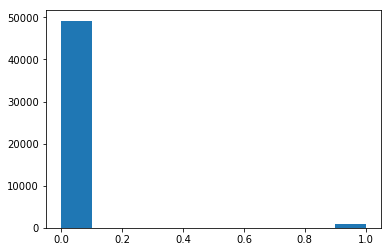

In [171]:
plt.hist(preds)
plt.show()

In [179]:
sub = {'id':id, 'Y':preds}
sub = pd.DataFrame(data=sub, columns=['id', 'Y'])
sub.to_csv('sub.csv', index=False)
sub.head()

,id,Y
0,49999,0
1,50000,0
2,50001,0
3,50002,0
4,50003,0


This gave a 0.56881 because I did not submit the probabilities.

In [190]:
preds = xgbln.predict_proba(one_test)

In [191]:
preds.shape

(50000, 2)

In [193]:
preds0 = preds[:, 0]
preds1 = preds[:, 1]

In [194]:
preds0

array([ 0.83156383,  0.99228519,  0.99327826, ...,  0.96392632,
        0.97688776,  0.96841645], dtype=float32)

In [195]:
sub = {'id':id, 'Y':preds0}
sub = pd.DataFrame(data=sub, columns=['id', 'Y'])
sub.to_csv('sub_probs0.csv', index=False)
sub.head()

,id,Y
0,49999,0.831564
1,50000,0.992285
2,50001,0.993278
3,50002,0.965103
4,50003,0.940870


This is a 0.85612. It just got real.

Lets continue playing with every parameter.

In [197]:
xgbreg = xgb.XGBClassifier( learning_rate=0.1, n_estimators=65, max_depth=5,
 min_child_weight=9, gamma=0, subsample=0.84, colsample_bytree=0.59,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
preg = {
    'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100],
    'reg_lambda':[1e-5, 1e-2, 0.1, 1, 100]
}
gsreg = sk.model_selection.GridSearchCV(estimator = xgbln,param_grid = preg, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsreg.fit(one_tr,y)
gsreg.grid_scores_, gsreg.best_params_, gsreg.best_score_

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85946, std: 0.00780, params: {'reg_alpha': 1e-05, 'reg_lambda': 1e-05},
  mean: 0.85950, std: 0.00781, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.01},
  mean: 0.85963, std: 0.00798, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.1},
  mean: 0.85995, std: 0.00717, params: {'reg_alpha': 1e-05, 'reg_lambda': 1},
  mean: 0.85928, std: 0.00723, params: {'reg_alpha': 1e-05, 'reg_lambda': 100},
  mean: 0.85958, std: 0.00787, params: {'reg_alpha': 0.01, 'reg_lambda': 1e-05},
  mean: 0.85957, std: 0.00785, params: {'reg_alpha': 0.01, 'reg_lambda': 0.01},
  mean: 0.85925, std: 0.00783, params: {'reg_alpha': 0.01, 'reg_lambda': 0.1},
  mean: 0.85970, std: 0.00700, params: {'reg_alpha': 0.01, 'reg_lambda': 1},
  mean: 0.85928, std: 0.00723, params: {'reg_alpha': 0.01, 'reg_lambda': 100},
  mean: 0.85946, std: 0.00747, params: {'reg_alpha': 0.1, 'reg_lambda': 1e-05},
  mean: 0.85944, std: 0.00786, params: {'reg_alpha': 0.1, 'reg_lambda': 0.01},
  mean: 0.85965, std: 0.00778, params: {'reg

Last Score: 0.85994825940986774
So it got marginally worse around the 9th digit. Time to get more precise.

Also I should define a function that does this.

In [200]:
def gcval(xgb, param):
    gsreg = sk.model_selection.GridSearchCV(estimator = xgb,param_grid = param, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
    gsreg.fit(one_tr,y)
    return gsreg.grid_scores_, gsreg.best_params_, gsreg.best_score_
    
xgbreg = xgb.XGBClassifier( learning_rate=0.1, n_estimators=65, max_depth=5,
 min_child_weight=9, gamma=0, subsample=0.84, colsample_bytree=0.59,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27)
preg = {
    'reg_alpha':[1e-7, 1e-5, 1e-3],
    'reg_lambda':[i/10.0 for i in range(6, 15)]
}
gcval(xgbreg, preg)

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.85968, std: 0.00745, params: {'reg_alpha': 1e-07, 'reg_lambda': 0.6},
  mean: 0.85966, std: 0.00791, params: {'reg_alpha': 1e-07, 'reg_lambda': 0.7},
  mean: 0.85938, std: 0.00767, params: {'reg_alpha': 1e-07, 'reg_lambda': 0.8},
  mean: 0.86008, std: 0.00730, params: {'reg_alpha': 1e-07, 'reg_lambda': 0.9},
  mean: 0.85995, std: 0.00717, params: {'reg_alpha': 1e-07, 'reg_lambda': 1.0},
  mean: 0.85984, std: 0.00719, params: {'reg_alpha': 1e-07, 'reg_lambda': 1.1},
  mean: 0.85964, std: 0.00759, params: {'reg_alpha': 1e-07, 'reg_lambda': 1.2},
  mean: 0.85986, std: 0.00791, params: {'reg_alpha': 1e-07, 'reg_lambda': 1.3},
  mean: 0.85946, std: 0.00770, params: {'reg_alpha': 1e-07, 'reg_lambda': 1.4},
  mean: 0.85968, std: 0.00745, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.6},
  mean: 0.85966, std: 0.00791, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.7},
  mean: 0.85938, std: 0.00767, params: {'reg_alpha': 1e-05, 'reg_lambda': 0.8},
  mean: 0.86008, std: 0.00730, params: {

Let's keep reg_lambda at 0.9 and get more accurate with reg_alpha.

In [201]:
xgbalpha = xgb.XGBClassifier(learning_rate=0.1, n_estimators=65, max_depth=5,
 min_child_weight=9, gamma=0, subsample=0.84, colsample_bytree=0.59,
 objective= 'binary:logistic', nthread=4, reg_lambda=0.9, scale_pos_weight=1,seed=27)
preg = {
    'reg_alpha':[1e-6, 1e-5, 1e-4]
}

In [203]:
gcval(xgbalpha, preg)

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86008, std: 0.00730, params: {'reg_alpha': 1e-06},
  mean: 0.86008, std: 0.00730, params: {'reg_alpha': 1e-05},
  mean: 0.86008, std: 0.00730, params: {'reg_alpha': 0.0001}],
 {'reg_alpha': 1e-05},
 0.86008397693122129)

In [204]:
xgbalpha = xgb.XGBClassifier(learning_rate=0.1, n_estimators=65, max_depth=5,
 min_child_weight=9, gamma=0, subsample=0.84, colsample_bytree=0.59,
 objective= 'binary:logistic', nthread=4, reg_lambda=0.9, scale_pos_weight=1,seed=27)
preg = {
    'reg_alpha':[(i/10.0)*1e-5 for i in range(6, 15)]
}
gcval(xgbalpha, preg)

/home/justin/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


([mean: 0.86008, std: 0.00730, params: {'reg_alpha': 6e-06},
  mean: 0.86008, std: 0.00730, params: {'reg_alpha': 7e-06},
  mean: 0.86008, std: 0.00730, params: {'reg_alpha': 8.000000000000001e-06},
  mean: 0.86008, std: 0.00730, params: {'reg_alpha': 9e-06},
  mean: 0.86008, std: 0.00730, params: {'reg_alpha': 1e-05},
  mean: 0.86008, std: 0.00730, params: {'reg_alpha': 1.1000000000000001e-05},
  mean: 0.86008, std: 0.00730, params: {'reg_alpha': 1.2e-05},
  mean: 0.86008, std: 0.00730, params: {'reg_alpha': 1.3000000000000001e-05},
  mean: 0.86008, std: 0.00730, params: {'reg_alpha': 1.4e-05}],
 {'reg_alpha': 8.000000000000001e-06},
 0.86008399288592519)

Through painstaking diligence, I have increased my score by 1.5954703891374322e-08.

I will submit this model, then do some more feature engineering.

In [206]:
xgb_nof = xgb.XGBClassifier(learning_rate=0.1, n_estimators=65, max_depth=5,
 min_child_weight=9, gamma=0, subsample=0.84, colsample_bytree=0.59,
 objective= 'binary:logistic', nthread=4, reg_lambda=0.9, reg_alpha=8e-6, scale_pos_weight=1,seed=27)

In [207]:
xgb_nof.fit(one_tr, y)
preds = xgb_nof.predict_proba(one_test)

In [208]:
preds

array([[ 0.81451672,  0.18548326],
       [ 0.99157917,  0.00842081],
       [ 0.99259466,  0.00740537],
       ..., 
       [ 0.95877701,  0.04122298],
       [ 0.97485334,  0.02514664],
       [ 0.96997577,  0.03002426]], dtype=float32)

In [211]:
preds0 = preds[:, 0]
data = {'id':id, 'Y':preds0}
sub = pd.DataFrame(data=data, columns=['id', 'Y'])
sub.to_csv('sub_before_feature_eng.csv', index=False)
sub.head()

,id,Y
0,49999,0.814517
1,50000,0.991579
2,50001,0.992595
3,50002,0.969228
4,50003,0.939587


n_estimators  65

Model Report
Accuracy : 0.9409
AUC Score (Train): 0.881070
run time:  0 m 11.9280860424 s


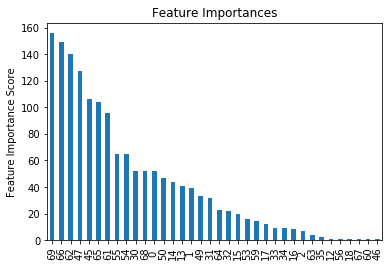

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.756128,0.010570,0.758399,0.002392
1,0.835175,0.013444,0.838432,0.015784
2,0.846108,0.004670,0.850201,0.005316
3,0.849837,0.003948,0.855308,0.002215
4,0.849551,0.004074,0.854466,0.002424
5,0.851795,0.003849,0.856619,0.001462
6,0.852423,0.003831,0.857652,0.001187
7,0.852723,0.004244,0.858412,0.001215
8,0.853379,0.004772,0.858966,0.000867
9,0.853655,0.004656,0.859892,0.001333


In [213]:
modelfit(xgb_nof, one_tr, y, predictors)

So far I have one hot encoded F2, F14, and F25. You can see my methodology above. I am going to get into the default dataset, and see how each feature stacks up.

In [219]:
xgb_def = xgb.XGBClassifier()
train_def = pd.read_csv('train_final.csv')
y = train_def['Y']
del train_def['Y']
predictors = [col for col in train_def.columns if (col != 'id')]

In [220]:
predictors

['F1',
 'F2',
 'F3',
 'F4',
 'F5',
 'F6',
 'F7',
 'F8',
 'F9',
 'F10',
 'F11',
 'F12',
 'F13',
 'F14',
 'F15',
 'F16',
 'F17',
 'F18',
 'F19',
 'F20',
 'F21',
 'F22',
 'F23',
 'F24',
 'F25',
 'F26',
 'F27']

n_estimators  100

Model Report
Accuracy : 0.9385
AUC Score (Train): 0.873742
run time:  0 m 9.25466704369 s


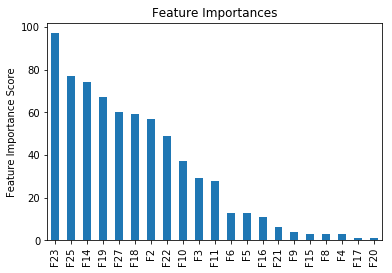

,test-auc-mean,test-auc-std,train-auc-mean,train-auc-std
0,0.803131,0.007250,0.809536,0.008575
1,0.819020,0.005538,0.824254,0.008761
2,0.828740,0.005068,0.832595,0.003113
3,0.833098,0.006495,0.835803,0.002114
4,0.836159,0.006670,0.839233,0.001124
5,0.836323,0.007263,0.840172,0.001592
6,0.837087,0.008048,0.840377,0.001665
7,0.837217,0.007954,0.840465,0.001708
8,0.838279,0.007280,0.841688,0.001759
9,0.839649,0.007524,0.842927,0.001478


In [222]:
modelfit(xgb_def, train_def, y, predictors)

Looking at the most important features, we can see that F25, F14, and F2 are all important. I will avoid touching these because I have previously onehot encoded them. I will look at each feature in order of importance and see if I can find a way to extract more data from them.

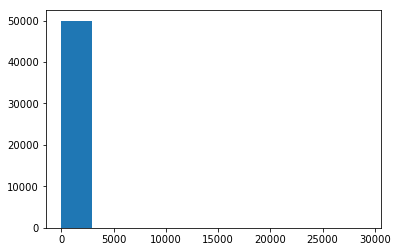

In [223]:
plt.hist(train_def['F23'])
plt.show()

In [224]:
train_def['F23']

0        0.042295
1        0.021417
2        0.502212
3        0.000000
4        0.787592
5        0.236217
6        0.000000
7        1.000000
8        0.122726
9        1.283746
10       0.062974
11       0.003782
12       0.037796
13       1.000000
14       0.051388
15       0.393430
16       0.383545
17       0.105818
18       0.441680
19       0.000000
20       0.066644
21       0.102281
22       0.261371
23       0.990646
24       0.520419
25       0.265985
26       0.035983
27       0.026228
28       0.026099
29       1.000000
           ...   
49968    0.080635
49969    0.000000
49970    0.842906
49971    0.023914
49972    0.006254
49973    0.000584
49974    0.198369
49975    0.016439
49976    0.002161
49977    0.990786
49978    0.476996
49979    0.902098
49980    0.373275
49981    0.034712
49982    0.009766
49983    1.000000
49984    0.097043
49985    0.185868
49986    0.109343
49987    0.000000
49988    0.256499
49989    0.000000
49990    0.014961
49991    0.718081
49992    0

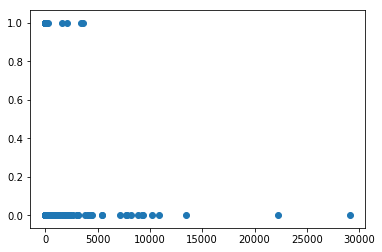

In [225]:
plt.scatter(train_def['F23'], y)
plt.show()

Well we can see why it is so important to the model.

Acutally, let's try to get value from the least important features.

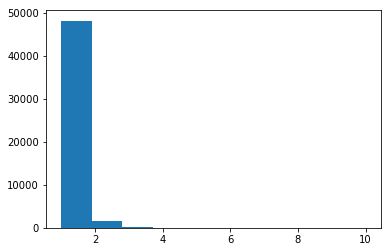

In [228]:
plt.hist(train_def['F20'])
plt.show()

In [231]:
f20 = [x for x in train_def['F20'] if x not in [1,2,3]]

In [232]:
f20

[6,
 4,
 4,
 4,
 7,
 4,
 4,
 4,
 10,
 4,
 4,
 4,
 4,
 4,
 4,
 5,
 5,
 4,
 8,
 5,
 4,
 4,
 5,
 6,
 5,
 5,
 4,
 5,
 4,
 4,
 4,
 4,
 7,
 4,
 4,
 4,
 4,
 4,
 9,
 4,
 5,
 4,
 4,
 5,
 4,
 4,
 4,
 4,
 6,
 8,
 6,
 4,
 5,
 5,
 4,
 4,
 6,
 6,
 4,
 5,
 4,
 4,
 6,
 6,
 5,
 4,
 4,
 5,
 6,
 4,
 4,
 5,
 4,
 5,
 5,
 6,
 5,
 5,
 4]

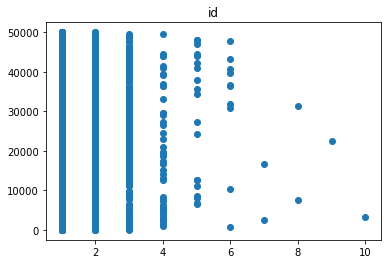

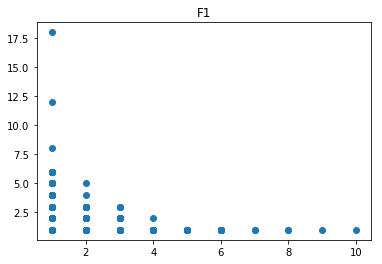

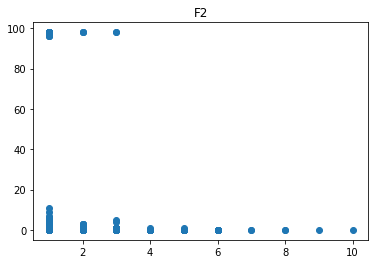

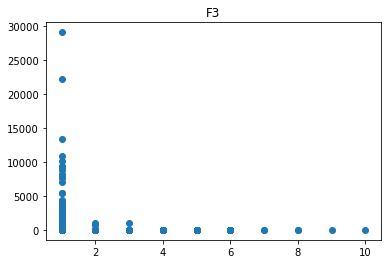

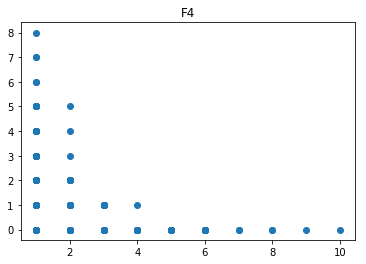

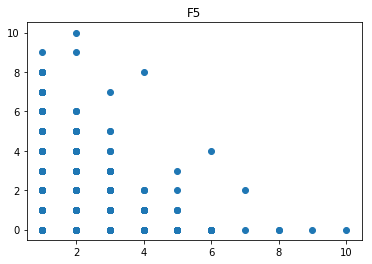

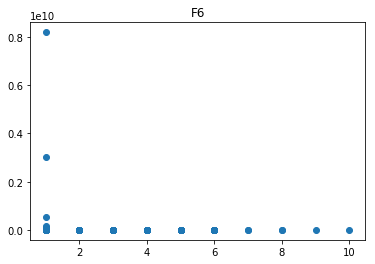

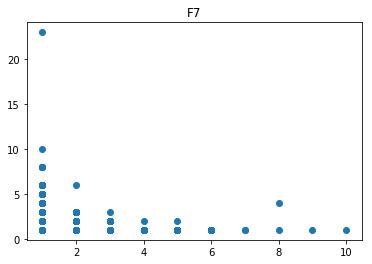

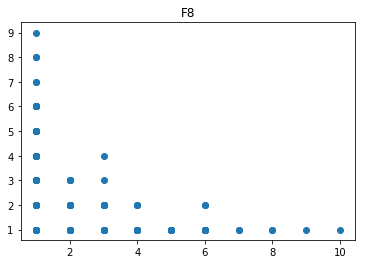

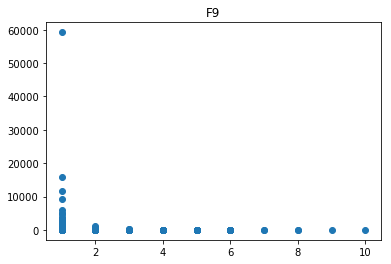

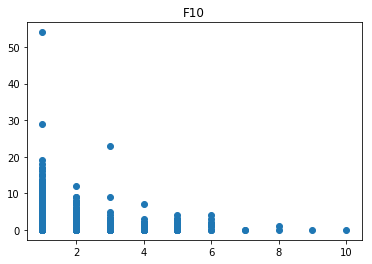

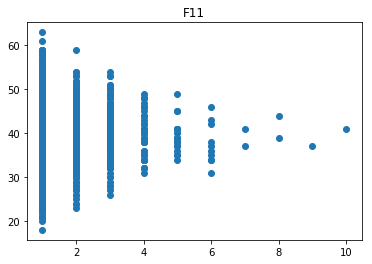

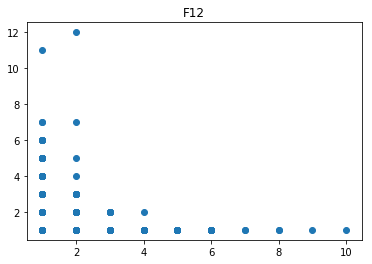

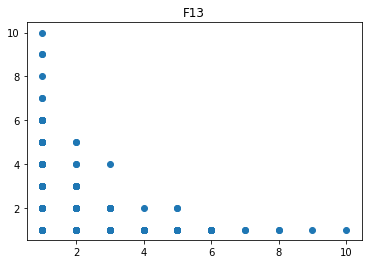

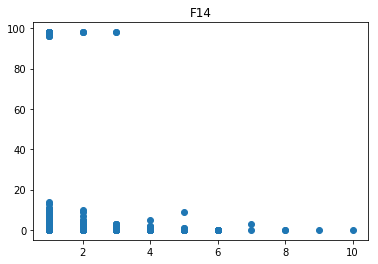

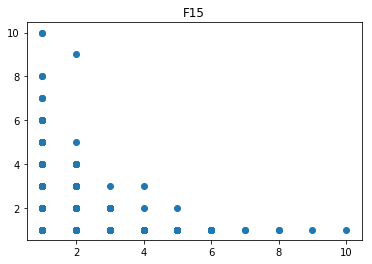

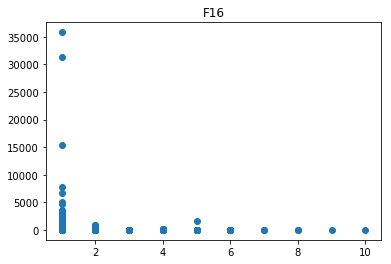

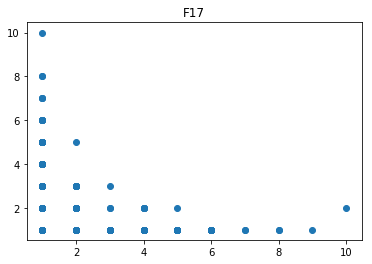

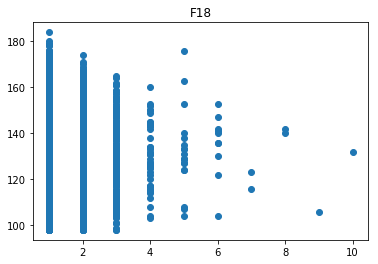

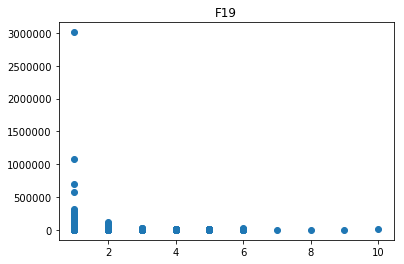

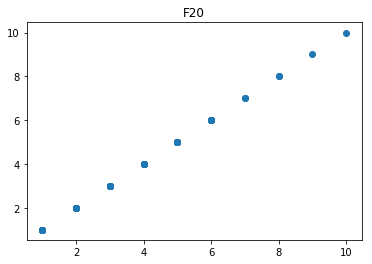

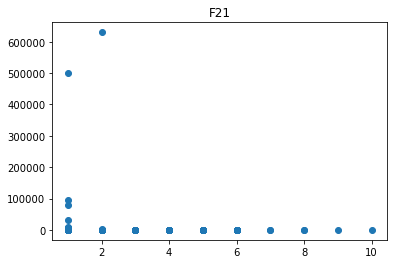

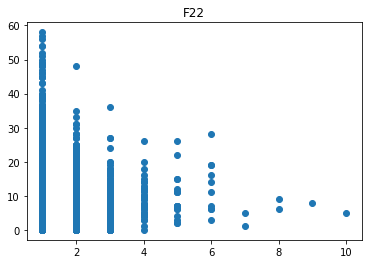

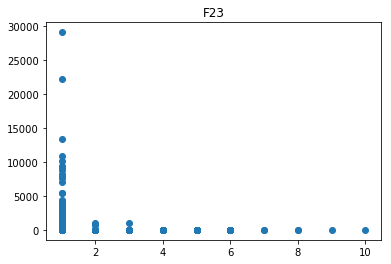

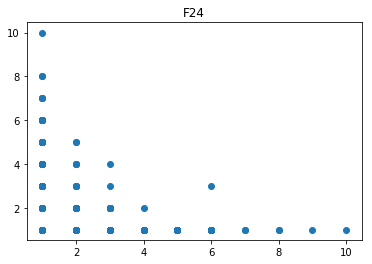

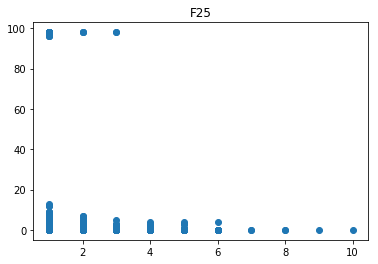

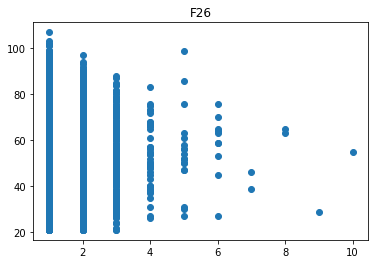

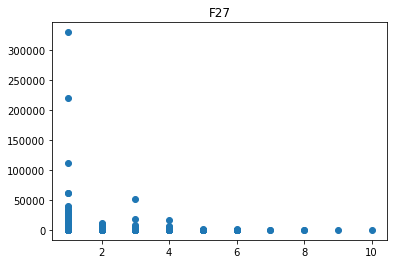

In [234]:
f20 = train_def['F20']
for col in train_def:
    plt.scatter(f20, train_def[col])
    plt.title(col)
    plt.show()

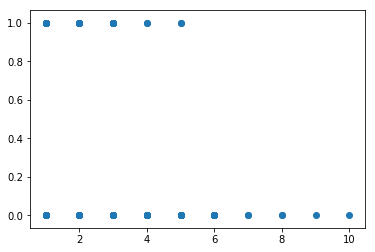

In [235]:
plt.scatter(f20, y)
plt.show()

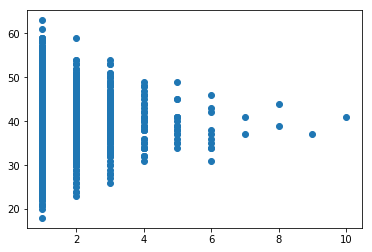

In [236]:
#F11 and F20 have a very interesting relationship
plt.scatter(f20, train_def['F11'])
plt.show()

In [237]:
f20log = np.log1p(f20)
f20ex = np.expm1(f20)

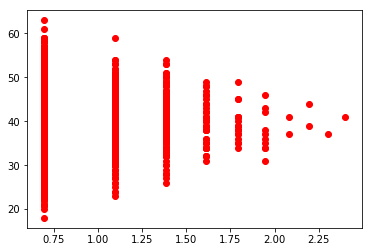

In [241]:
plt.scatter(f20log, train_def['F11'], c='r')
#plt.scatter(f20ex, train_def['F11'], c='b')
plt.show()

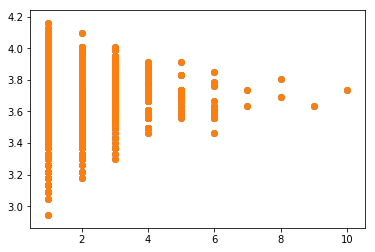

In [243]:
f11log = np.log1p(train_def['F11'])
plt.scatter(f20, f11log)
plt.show()

In [244]:
newF = f20*train_def['F11']

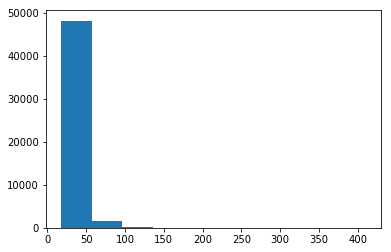

In [245]:
plt.hist(newF)
plt.show()

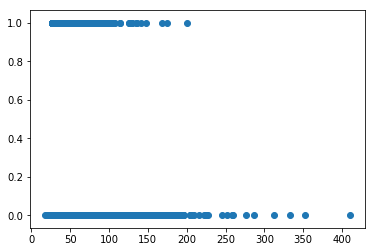

In [246]:
plt.scatter(newF, y)
plt.show()

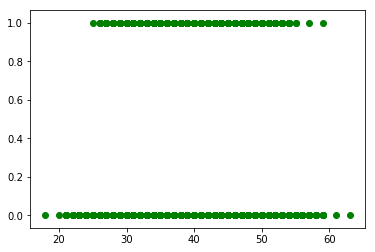

In [247]:
plt.scatter(train_def['F11'], y, c='g')
plt.show()

In [249]:
trainy = pd.read_csv('train_final.csv')

In [256]:
trainy.head()

,id,Y,F1,F2,F3,F4,F5,F6,F7,F8,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
0,1,0,1,0,0.107576,0,0.0,1,1,1,...,104,22902.0,1,0,18,0.042295,1,0,27,0.028250
1,2,0,1,0,0.142357,0,0.0,7,1,1,...,144,11400.0,1,0,8,0.021417,1,0,67,0.253574
2,3,0,1,0,0.492318,0,3.0,4205,1,1,...,112,4833.0,1,0,13,0.502212,1,1,35,0.373397
3,4,0,1,0,-0.053028,0,2.0,2,1,1,...,127,3250.0,1,1,8,0.000000,1,0,50,0.674254
4,5,0,1,0,0.730797,0,0.0,11,1,1,...,148,4000.0,1,1,5,0.787592,1,0,71,0.371157


In [257]:
train1 = trainy.loc[trainy['Y'] == 1]

In [258]:
train1.head()

,id,Y,F1,F2,F3,F4,F5,F6,F7,F8,...,F18,F19,F20,F21,F22,F23,F24,F25,F26,F27
13,14,1,1,1,1.203383,0,0.0,31,1,1,...,100,1600.0,1,0,5,1.000000,1,0,23,0.202374
18,19,1,1,0,0.663904,0,3.0,4,1,1,...,123,4000.0,1,0,14,0.441680,1,3,46,0.561360
35,36,1,1,0,0.547685,0,2.0,1,1,1,...,124,6233.0,1,32,8,0.601297,1,0,47,0.312320
37,38,1,1,0,-0.014629,0,2.0,4,1,1,...,122,5016.0,1,0,11,0.014570,1,1,45,1.336655
69,70,1,1,3,1.212781,0,0.0,1,1,1,...,103,1400.0,1,0,8,1.074985,1,2,26,0.711635


In [259]:
train0 = trainy.loc[trainy['Y'] != 1]

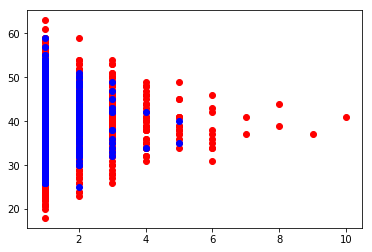

In [260]:
plt.scatter(train0['F20'], train0['F11'], c='r')
plt.scatter(train1['F20'], train1['F11'], c='b')
plt.show()

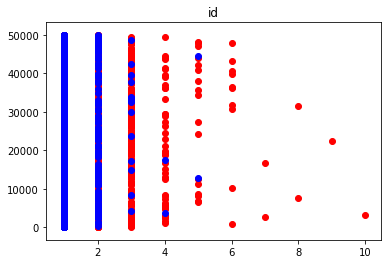

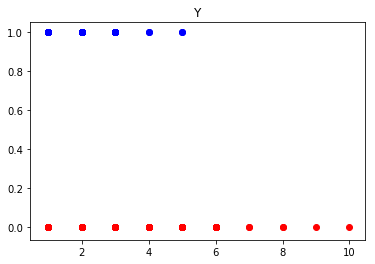

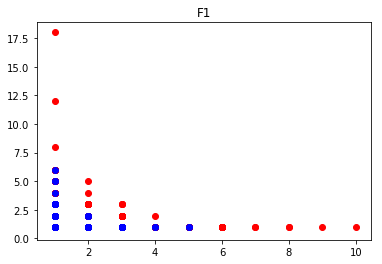

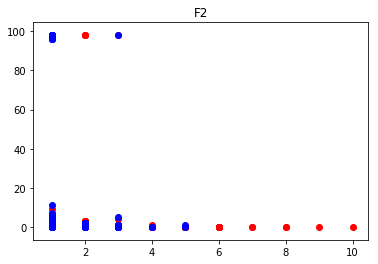

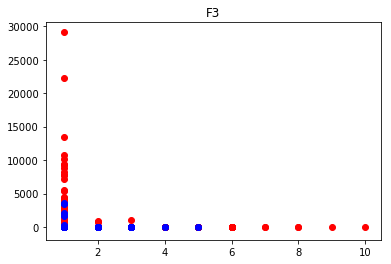

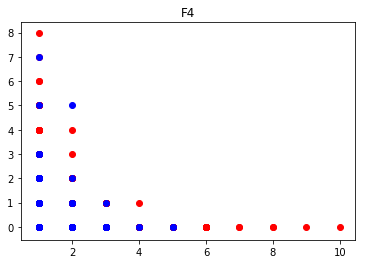

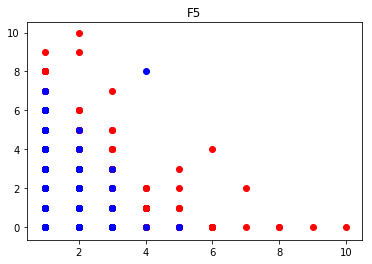

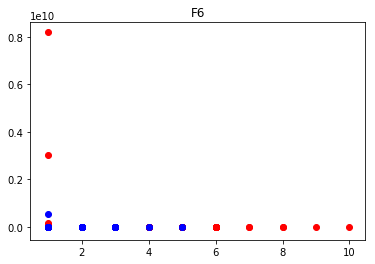

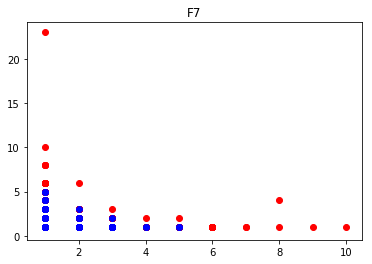

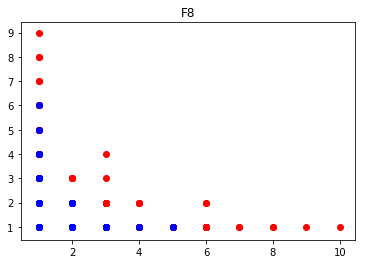

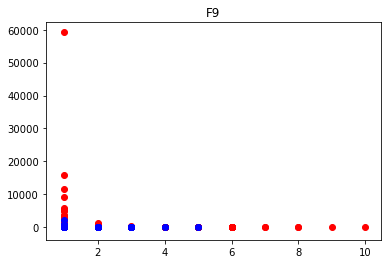

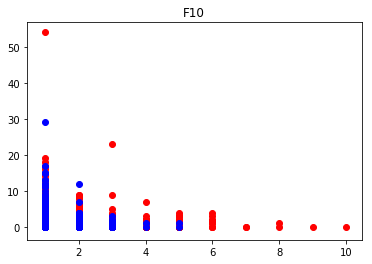

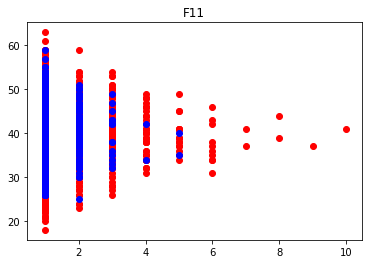

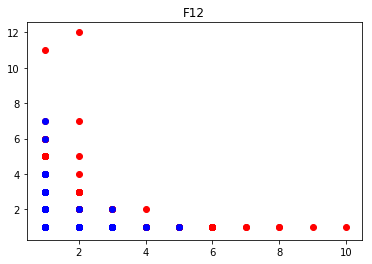

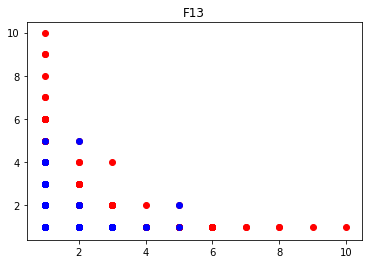

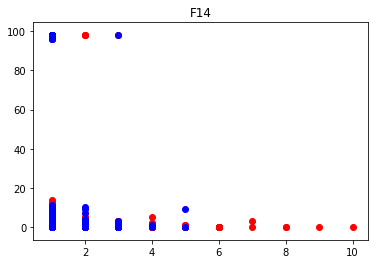

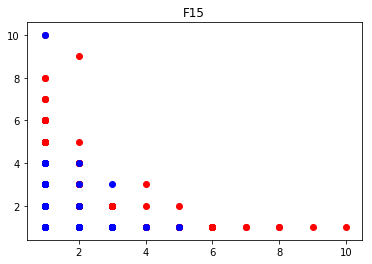

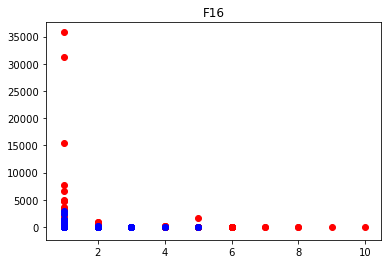

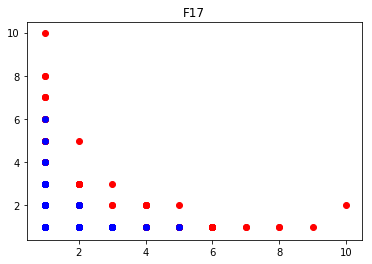

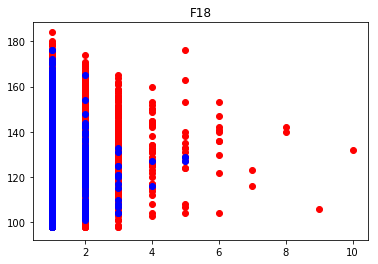

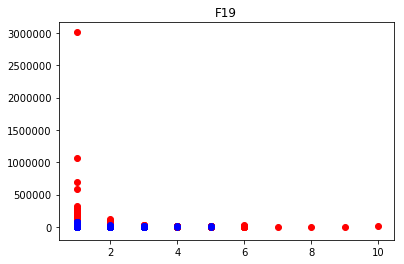

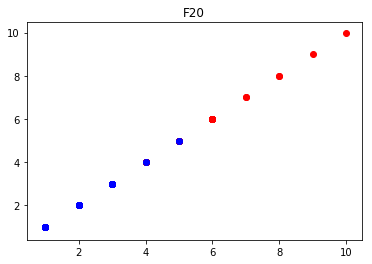

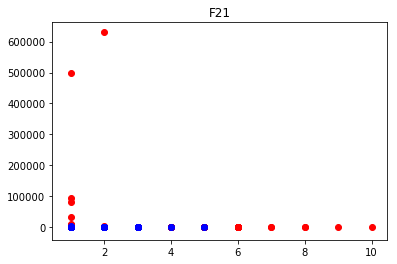

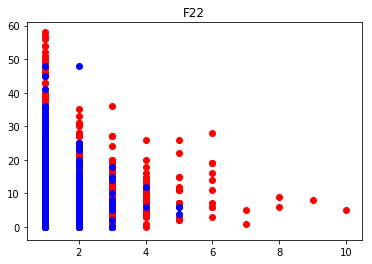

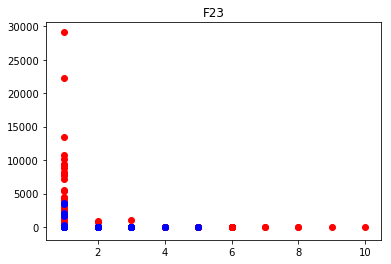

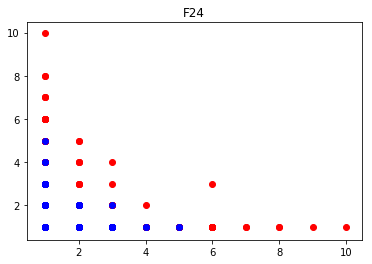

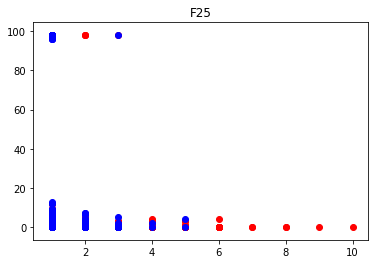

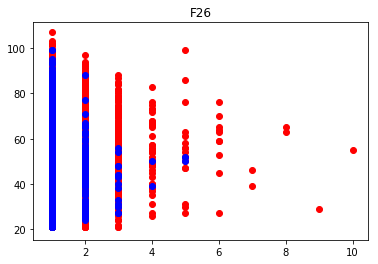

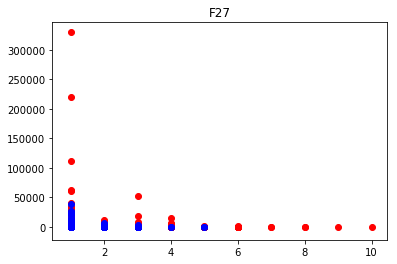

In [263]:
for col in trainy:
    plt.scatter(train0['F20'], train0[col], c='r')
    plt.scatter(train1['F20'], train1[col], c='b')
    plt.title(col)
    plt.show()

In [264]:
newF0 = train0['F20']*train0['F11']
newF1 = train1['F20']*train1['F11']
train0['newF'] = pd.Series(newF0, index=train0.index)
train1['newF'] = pd.Series(newF1, index=train1.index)

/home/justin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/justin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [265]:
train0.head()

,id,Y,F1,F2,F3,F4,F5,F6,F7,F8,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,newF
0,1,0,1,0,0.107576,0,0.0,1,1,1,...,22902.0,1,0,18,0.042295,1,0,27,0.028250,32
1,2,0,1,0,0.142357,0,0.0,7,1,1,...,11400.0,1,0,8,0.021417,1,0,67,0.253574,44
2,3,0,1,0,0.492318,0,3.0,4205,1,1,...,4833.0,1,0,13,0.502212,1,1,35,0.373397,32
3,4,0,1,0,-0.053028,0,2.0,2,1,1,...,3250.0,1,1,8,0.000000,1,0,50,0.674254,46
4,5,0,1,0,0.730797,0,0.0,11,1,1,...,4000.0,1,1,5,0.787592,1,0,71,0.371157,35


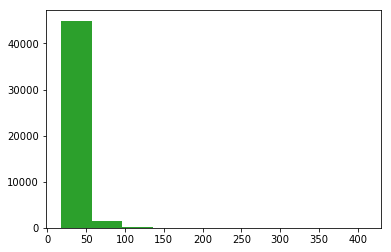

In [268]:
plt.hist(train0['newF'])
#plt.hist(train1['newF'], c='r')
plt.show()

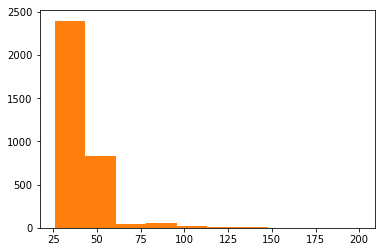

In [270]:
plt.hist(train1['newF'])
plt.show()

In [271]:
newF_f22_f20 = trainy['F20']*trainy['F11']
trainy['F30'] = pd.Series(newF_f22_f20, index=trainy.index)

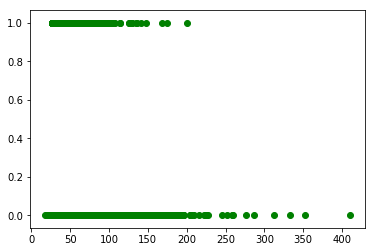

In [272]:
plt.scatter(trainy['F30'], trainy['Y'], c='g')
plt.show()

In [280]:
def modelfit2(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[target],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "Accuracy : %.4g" % metrics.accuracy_score(dtrain[target].values, dtrain_predictions)
    print "AUC Score (Train): %f" % metrics.roc_auc_score(dtrain[target], dtrain_predprob)
                    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    plt.show()


Model Report
Accuracy : 0.9383
AUC Score (Train): 0.873034


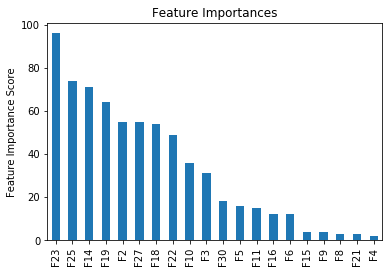

In [282]:
target='Y'
predictors = [x for x in trainy.columns if x not in ['Y', 'id']]
modelfit2(xgb_def, trainy, predictors)


Model Report
Accuracy : 0.9385
AUC Score (Train): 0.873742


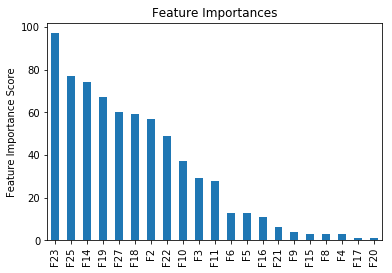

In [283]:
target='Y'
predictors = [x for x in trainy.columns if x not in ['Y', 'id', 'F30']]
modelfit2(xgb_def, trainy, predictors)

This new feature seems to have made things worse.
lol

In [284]:
del trainy['F30'] #saved as newF_f22_f20

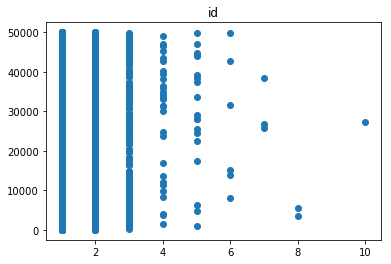

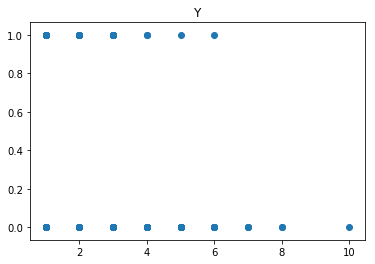

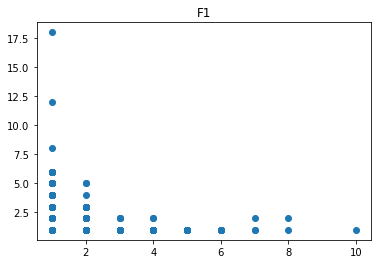

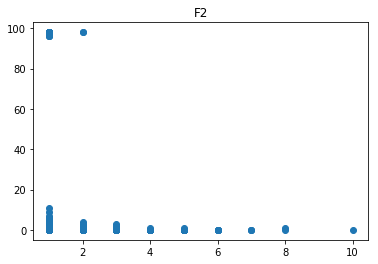

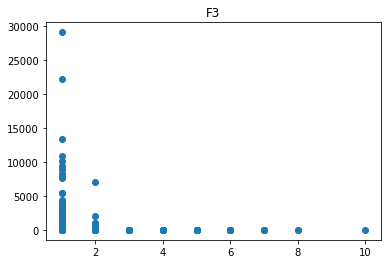

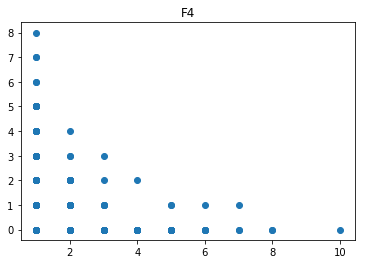

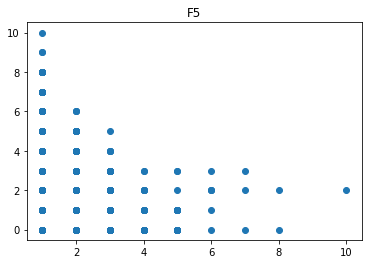

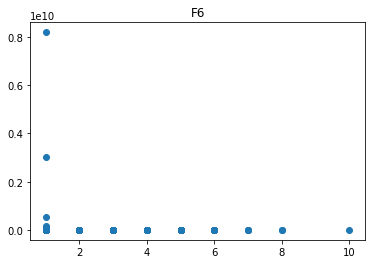

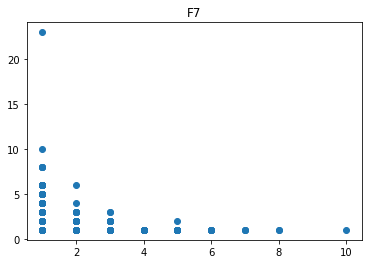

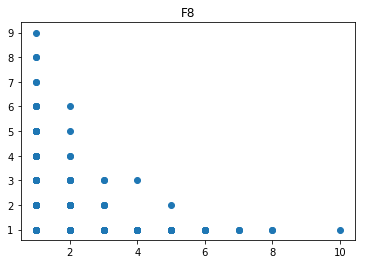

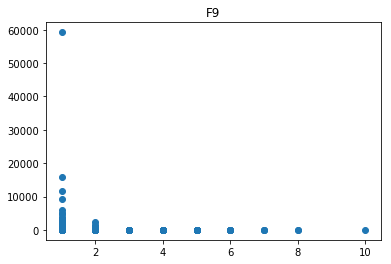

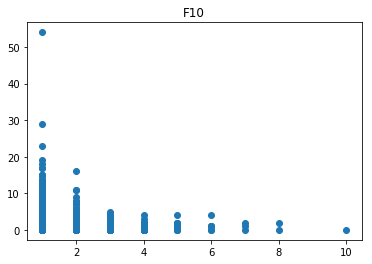

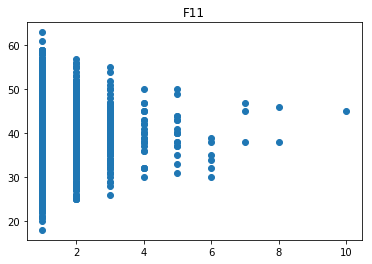

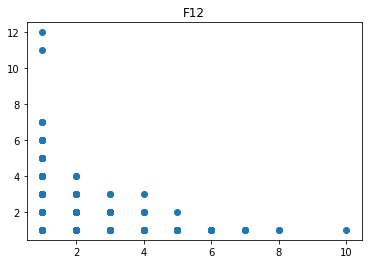

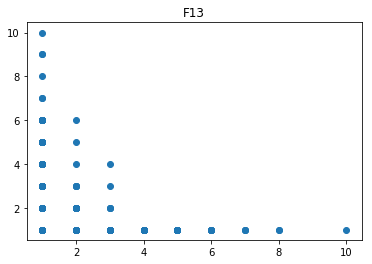

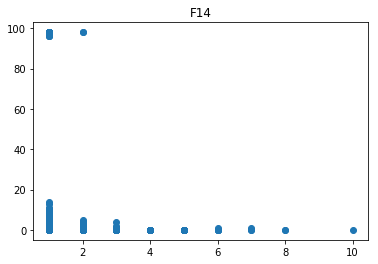

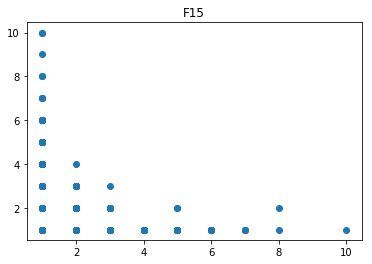

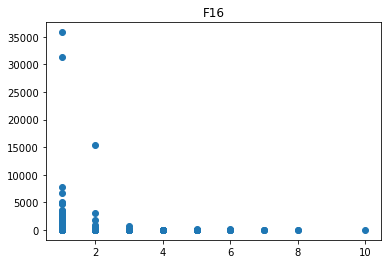

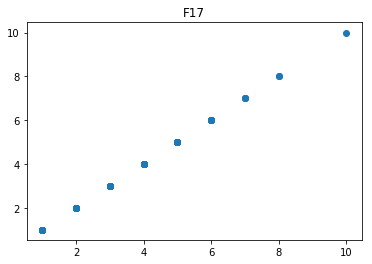

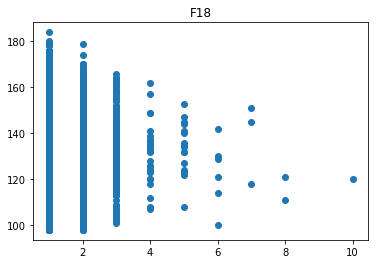

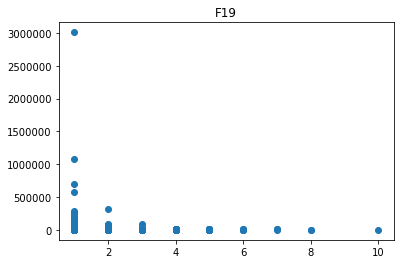

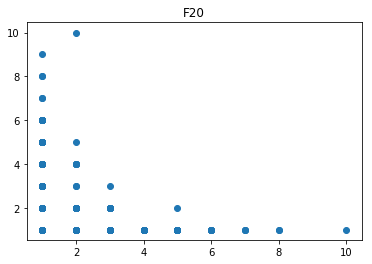

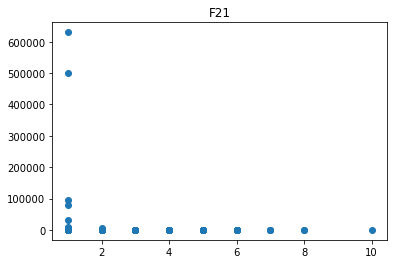

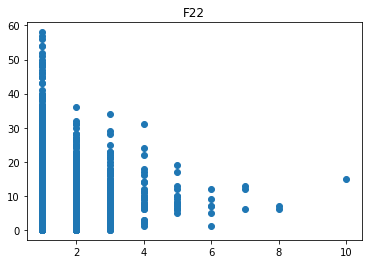

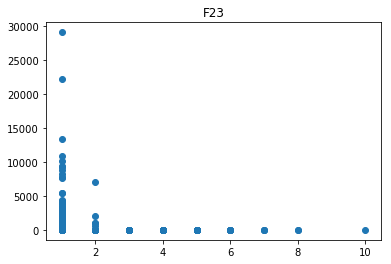

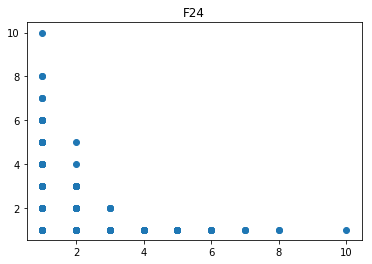

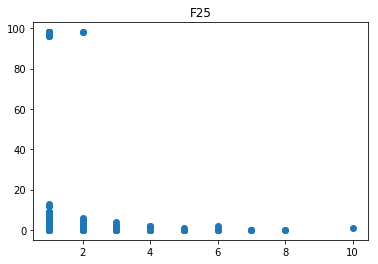

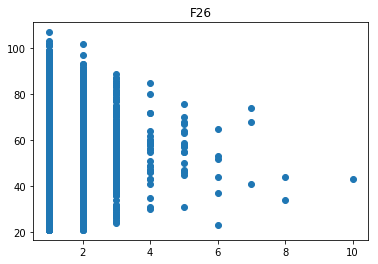

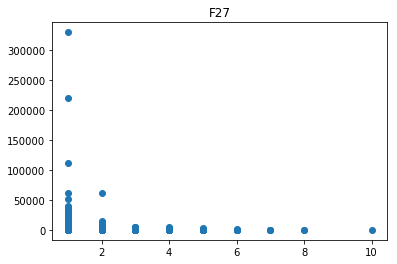

In [285]:
for col in trainy.columns:
    plt.scatter(trainy['F17'], trainy[col])
    plt.title(col)
    plt.show()

This feature (F17) is almost identical to F20. Also they both suck at predicting in their current form. Let's try multiplying them together.

In [286]:
newF1720 = trainy['F17']*trainy['F20']
trainy['F30'] = pd.Series(newF1720, index=trainy.index)

In [287]:
trainy.head()

,id,Y,F1,F2,F3,F4,F5,F6,F7,F8,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F30
0,1,0,1,0,0.107576,0,0.0,1,1,1,...,22902.0,1,0,18,0.042295,1,0,27,0.028250,1
1,2,0,1,0,0.142357,0,0.0,7,1,1,...,11400.0,1,0,8,0.021417,1,0,67,0.253574,1
2,3,0,1,0,0.492318,0,3.0,4205,1,1,...,4833.0,1,0,13,0.502212,1,1,35,0.373397,1
3,4,0,1,0,-0.053028,0,2.0,2,1,1,...,3250.0,1,1,8,0.000000,1,0,50,0.674254,1
4,5,0,1,0,0.730797,0,0.0,11,1,1,...,4000.0,1,1,5,0.787592,1,0,71,0.371157,2



Model Report
Accuracy : 0.9385
AUC Score (Train): 0.873742


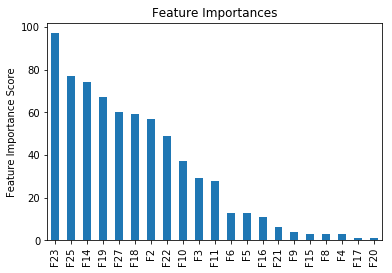

In [288]:
target='Y'
predictors = [x for x in trainy.columns if x not in ['Y', 'id']]
modelfit2(xgb_def, trainy, predictors)

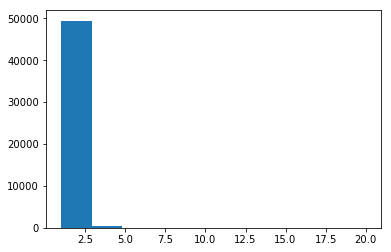

In [291]:
plt.hist(trainy['F30'])
plt.show()